# Pesquisa Pecuária Municipal

Aluno: Jamesson Leandro Paiva Santos

## Introdução

Compreender os dados sobre rebanhos e aquicultura no Brasil é desvendar os pilares que sustentam a economia de muitas cidades e o alimento que chega às nossas mesas. Esses números mostram muito mais do que quantidade ou valor: eles refletem tendências de mercado, mudanças no consumo, avanços tecnológicos e até os impactos de questões ambientais e sociais. Analisar essas informações é como ter um mapa que guia o crescimento sustentável e aponta onde estão as oportunidades e os desafios.

Além disso, entender como o Brasil se posiciona na produção animal e aquícola é estratégico para fortalecer sua competitividade global. Ao identificar padrões de crescimento e regiões com maior potencial, é possível criar políticas públicas mais eficientes, atrair investimentos e impulsionar o desenvolvimento local. Essas análises ajudam a transformar dados em ações que conectam o campo às cidades, geram empregos e garantem o futuro de uma das maiores potências agropecuárias do mundo.


## Fontes de Dados

Os dados utilizados nesse projeto foram obtidos no [site do IBGE](https://basedosdados.org/dataset/f7df4160-7a6f-4658-a287-3a73d412ed10?table=ff7d91a7-4482-4097-8b73-82d02f17a8c0), mais especificamente na seção de Pesquisa Pecuária Municipal. Essa pesquisa é realizada anualmente e coleta informações sobre a produção de animais e aquicultura em todos os municípios brasileiros. Os dados são divididos em diferentes categorias, como bovinos, suínos, aves, leite, ovos, peixes, entre outros. Cada categoria contém informações sobre a quantidade produzida, o valor da produção e o efetivo de animais.

De forma complementar, dados geoespaciais sobre [municípios](https://basedosdados.org/dataset/49ace9c8-ae2d-454b-bed9-9b9492a3a642?table=b39609b4-ffb2-4b4f-a182-47b0d160037b) e [regiões](https://basedosdados.org/dataset/49ace9c8-ae2d-454b-bed9-9b9492a3a642?table=4b1c9db7-35a7-460e-ba38-336bb376f699) brasileiras também foram obtidos para enriquecer a análise.

## Configuração do ambiente e bibliotecas

In [1]:
import pandas as pd
import numpy as np
import gzip
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from plotnine import *
from shapely import wkt
from matplotlib import cm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Configura tema dos gráficos usando seaborn
theme_set(theme_seaborn(style="ticks", font="Arial"));

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configura resolução dos gráficos para alta resolução
%config InlineBackend.figure_format = 'retina'

In [4]:
# Variáveis globais
ONE_BILLION = 1_000_000_000
ONE_MILLION = 1_000_000
ONE_TONNE = 1_000

## Carregamento dos dados

In [5]:
def open_gzipped_csv(file_path: str) -> pd.DataFrame:
	with gzip.open(file_path, 'rt') as f:
		return pd.read_csv(f)


flock_df = open_gzipped_csv('data/br_ibge_ppm_efetivo_rebanhos.csv.gz')
aquaculture_df = open_gzipped_csv('data/br_ibge_ppm_producao_aquicultura.csv.gz')
cities_df = open_gzipped_csv('data/br_bd_diretorios_brasil_municipio.csv.gz') # metadata

Carregamento de dados geográficos dos municípios, estados e regiões.

In [6]:
regions_map_df = pd.read_csv("data/br_geobr_mapas_regiao.csv")
cities_map_df = pd.read_csv("data/br_geobr_mapas_municipio.csv")
states_map_df = pd.read_csv("data/br_geobr_mapas_uf.csv")

# Converte a coluna de geometria (WKT) para objetos geoespaciais
regions_map_df['geometria'] = regions_map_df['geometria'].apply(wkt.loads)
cities_map_df['geometria'] = cities_map_df['geometria'].apply(wkt.loads)
states_map_df['geometria'] = states_map_df['geometria'].apply(wkt.loads)

# Cria o GeoDataFrame
cities_gdf = gpd.GeoDataFrame(cities_map_df, geometry='geometria')
states_gdf = gpd.GeoDataFrame(states_map_df, geometry='geometria')
regions_gdf = gpd.GeoDataFrame(regions_map_df, geometry='geometria')

# Define o sistema de coordenadas (CRS)
cities_gdf.set_crs(epsg=4326, inplace=True)
states_gdf.set_crs(epsg=4326, inplace=True)
regions_gdf.set_crs(epsg=4326, inplace=True);

In [7]:
cities_gdf.head(1)

,id_municipio,sigla_uf,geometria
0,1200336,AC,"POLYGON ((-73.80156 -7.11182, -73.79209 -7.123..."


Os dados geográficos de cidades e regiões vêm apenas com os valores de `id` de referência, então é necessário fazer o merge com os dados de municípios e regiões para obter os nomes.

In [8]:
# Adiciona nome do estado ao GeoDataFrame de estados
states_gdf = states_gdf.merge(
	cities_df.filter(['nome_uf', 'id_uf', 'sigla_uf']).drop_duplicates(),
	how='left',
	left_on='id_uf',
	right_on='id_uf'
).rename(columns={'sigla_uf_y': 'sigla_uf'})

# Adiciona nome da cidade e do estado ao GeoDataFrame de cidades
cities_gdf = cities_gdf.merge(
	cities_df.filter(['nome', 'id_municipio', 'nome_uf', 'sigla_uf']).drop_duplicates(),
	how='left',
	left_on='id_municipio',
	right_on='id_municipio'
).rename(columns={'nome_uf_y': 'nome_uf', 'sigla_uf_y': 'sigla_uf'})

In [9]:
def fill_cities_names(df: pd.DataFrame) -> pd.DataFrame:
	df = df.merge(
		cities_df[['id_municipio', 'nome', 'nome_uf', 'nome_regiao', 'centroide']], 
		left_on='id_municipio', 
		right_on='id_municipio'
	)

	df.rename(columns={'nome': 'municipio'}, inplace=True)

	return df

flock_df = fill_cities_names(flock_df)
aquaculture_df = fill_cities_names(aquaculture_df)

## Aquicultura

A aquicultura é o cultivo controlado de organismos aquáticos, como peixes, moluscos, crustáceos e plantas aquáticas, em ambientes artificiais ou naturais. A aquicultura envolve técnicas variadas, desde sistemas intensivos em tanques ou gaiolas até métodos mais tradicionais em lagos ou viveiros, com o objetivo de maximizar a produtividade e minimizar impactos ambientais.

A base de dados da Pesquisa Pecuária Municipal contém informações sobre a produção de peixes em todos os municípios brasileiros. Vamos analisar esses dados para entender como a aquicultura se distribui pelo país e quais são os principais produtos e regiões.

In [10]:
aquaculture_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87724 entries, 0 to 87723
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ano           87724 non-null  int64 
 1   sigla_uf      87724 non-null  object
 2   id_municipio  87724 non-null  int64 
 3   produto       87724 non-null  object
 4   quantidade    87724 non-null  int64 
 5   valor         87724 non-null  int64 
 6   municipio     87724 non-null  object
 7   nome_uf       87724 non-null  object
 8   nome_regiao   87724 non-null  object
 9   centroide     87724 non-null  object
dtypes: int64(4), object(6)
memory usage: 6.7+ MB


### Entendendo os dados

A base de dados, originalmente, contém as seguintes colunas:


| Nome da Variável     | Significado                                   | Tipo de Dado |
|----------------------|-----------------------------------------------|--------------|
| `ano`                | Ano de referência da informação               | Numérico     |
| `id_municipio`       | Código IBGE do município                      | Numérico     |
| `sigla_uf`           | Sigla da Unidade da Federação                 | Texto        |
| `produto`            | Produto                                       | Texto        |
| `quantidade`         | Quantidade da produção (kg)                   | Numérico     |
| `valor`              | Valor da produção (1000∗brl)                  | Numérico     |

### Análise Exploratória

In [11]:
aquaculture_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87724 entries, 0 to 87723
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ano           87724 non-null  int64 
 1   sigla_uf      87724 non-null  object
 2   id_municipio  87724 non-null  int64 
 3   produto       87724 non-null  object
 4   quantidade    87724 non-null  int64 
 5   valor         87724 non-null  int64 
 6   municipio     87724 non-null  object
 7   nome_uf       87724 non-null  object
 8   nome_regiao   87724 non-null  object
 9   centroide     87724 non-null  object
dtypes: int64(4), object(6)
memory usage: 6.7+ MB


In [12]:
aquaculture_df.head(1)

,ano,sigla_uf,id_municipio,produto,quantidade,valor,municipio,nome_uf,nome_regiao,centroide
0,2020,MA,2102903,Carpa,1500,13,Carutapera,Maranhão,Nordeste,POINT(-46.026421272492 -1.34791520411474)


In [13]:
# Valores nulos
aquaculture_df.isnull().sum().sort_values(ascending=False)

ano             0
sigla_uf        0
id_municipio    0
produto         0
quantidade      0
valor           0
municipio       0
nome_uf         0
nome_regiao     0
centroide       0
dtype: int64

In [14]:
# Anos disponíveis (ordenado)
aquaculture_df.ano.sort_values().unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [15]:
# Tipos de produtos
aquaculture_df.produto.unique()

array(['Carpa', 'Truta', 'Dourado', 'Lambari', 'Alevinos', 'Camarão',
       'Pirarucu', 'Tambaqui', 'Tilápia', 'Matrinxã', 'Tucunaré',
       'Pirapitinga', 'Outros peixes', 'Pacu e patinga',
       'Traíra e trairão', 'Tambacu, tambatinga', 'Sementes de moluscos',
       'Curimatã, curimbatá', 'Ostras, vieiras e mexilhões',
       'Piau, piapara, piauçu, piava', 'Larvas e pós-larvas de camarão',
       'Jatuarana, piabanha e piracanjuba',
       'Pintado, cachara, cachapira e pintachara, surubim'], dtype=object)

Para facilitar a análise, vamos criar uma coluna para armazenar a quantidade produzida já em toneladas e o valor da produção em milhões de reais.

In [16]:
# Quantidade para toneladas
aquaculture_df = aquaculture_df.assign(quantidade=lambda _: _.quantidade / ONE_TONNE)

# Valor produzido para milhões de reais
aquaculture_df = aquaculture_df.assign(valor=lambda _: (_.valor * 1_000) / ONE_MILLION)

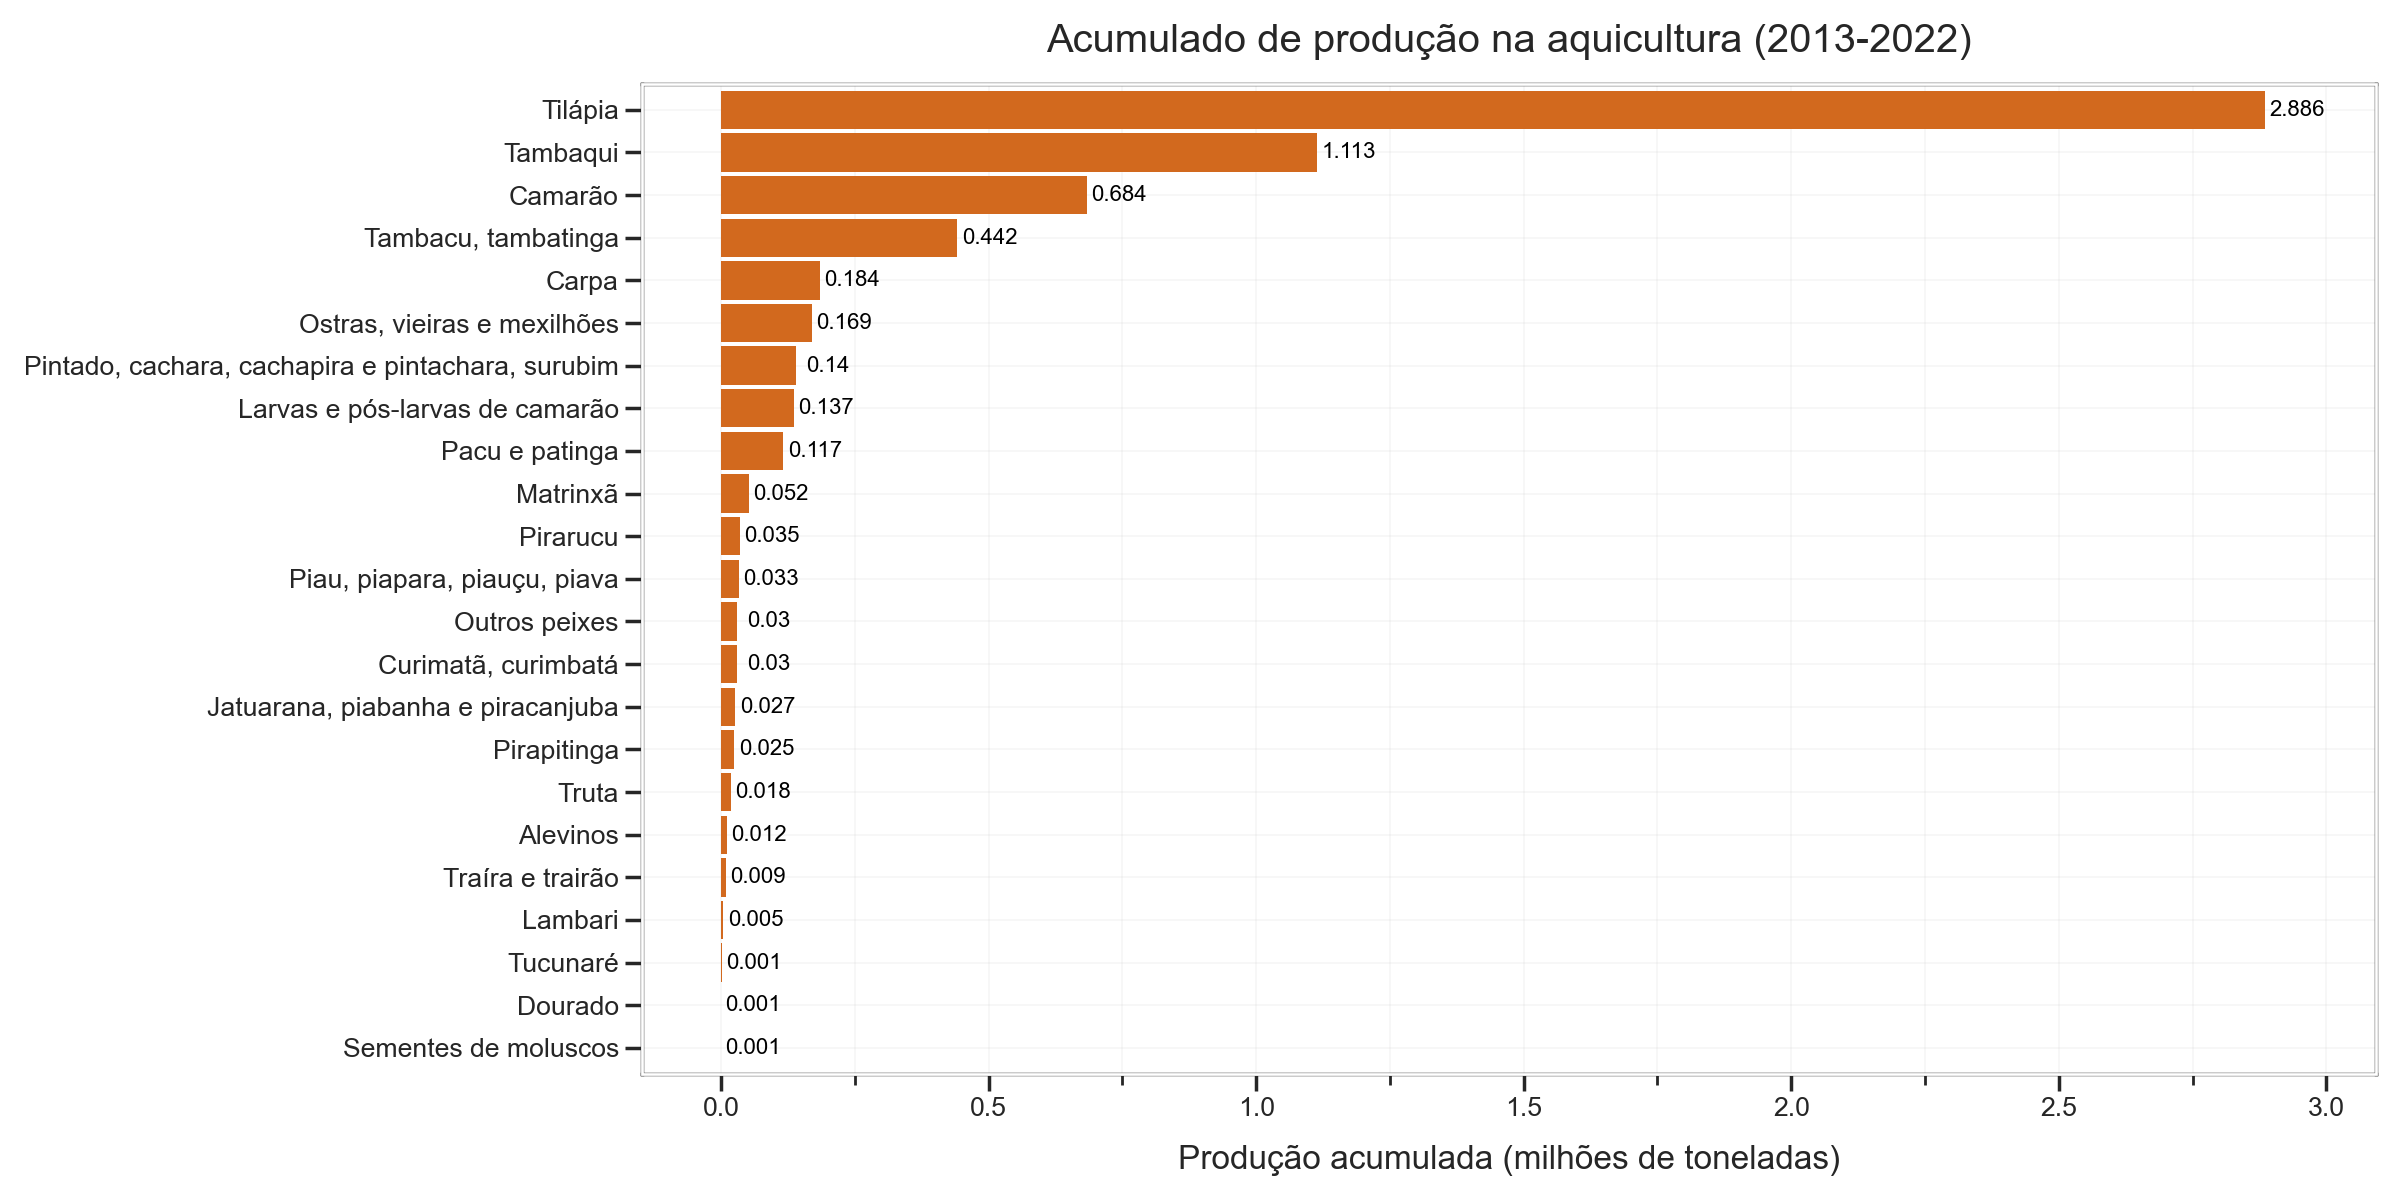

In [17]:
# Agrupa por 'produto' e soma as quantidades
aquacultures_by_type = (aquaculture_df
	.groupby('produto')
	.agg({'quantidade': 'sum'})
	.assign(quantidade_milhoes_toneladas=lambda _: _.quantidade / ONE_MILLION)
	.reset_index()
)

plot = (ggplot(aquacultures_by_type,
	aes(x='reorder(produto, quantidade_milhoes_toneladas)', y='quantidade_milhoes_toneladas'))
	+ geom_bar(stat='identity', fill='chocolate')
	+ geom_text(
		aes(label=aquacultures_by_type.quantidade_milhoes_toneladas.round(3)),
			va='center', ha='center', nudge_y=0.06, nudge_x=0,
			size=8
		)
	+ theme(
		figure_size=(12, 6),
		panel_grid=element_line(size=0.1),
	)
	+ scale_y_continuous(breaks=np.arange(0, 3.5, 0.5))
	+ coord_flip()
	+ labs(
		title='Acumulado de produção na aquicultura (2013-2022)',
		x='',
		y='Produção acumulada (milhões de toneladas)'
	)
)

plot.show()

O gráfico apresenta o acumulado de produção na aquicultura brasileira entre 2013 e 2022, em milhões de toneladas. A **Tilápia** destaca-se como o principal produto, com aproximadamente 2,89 milhões de toneladas, representando uma diferença expressiva em relação aos demais. O **Tambaqui** ocupa a segunda posição, com 1,11 milhões de toneladas, enquanto o **Camarão** aparece em terceiro, com 0,68 milhões de toneladas.

Os demais produtos possuem volumes significativamente menores, como o **Tambacu, tambatinga** (0,44 milhões) e a **Carpa** (0,18 milhões). Este padrão evidencia a dominância de poucos produtos no setor, com a Tilápia liderando amplamente a produção no período analisado. A diversidade de espécies é alta, mas a produção concentra-se em poucas delas.

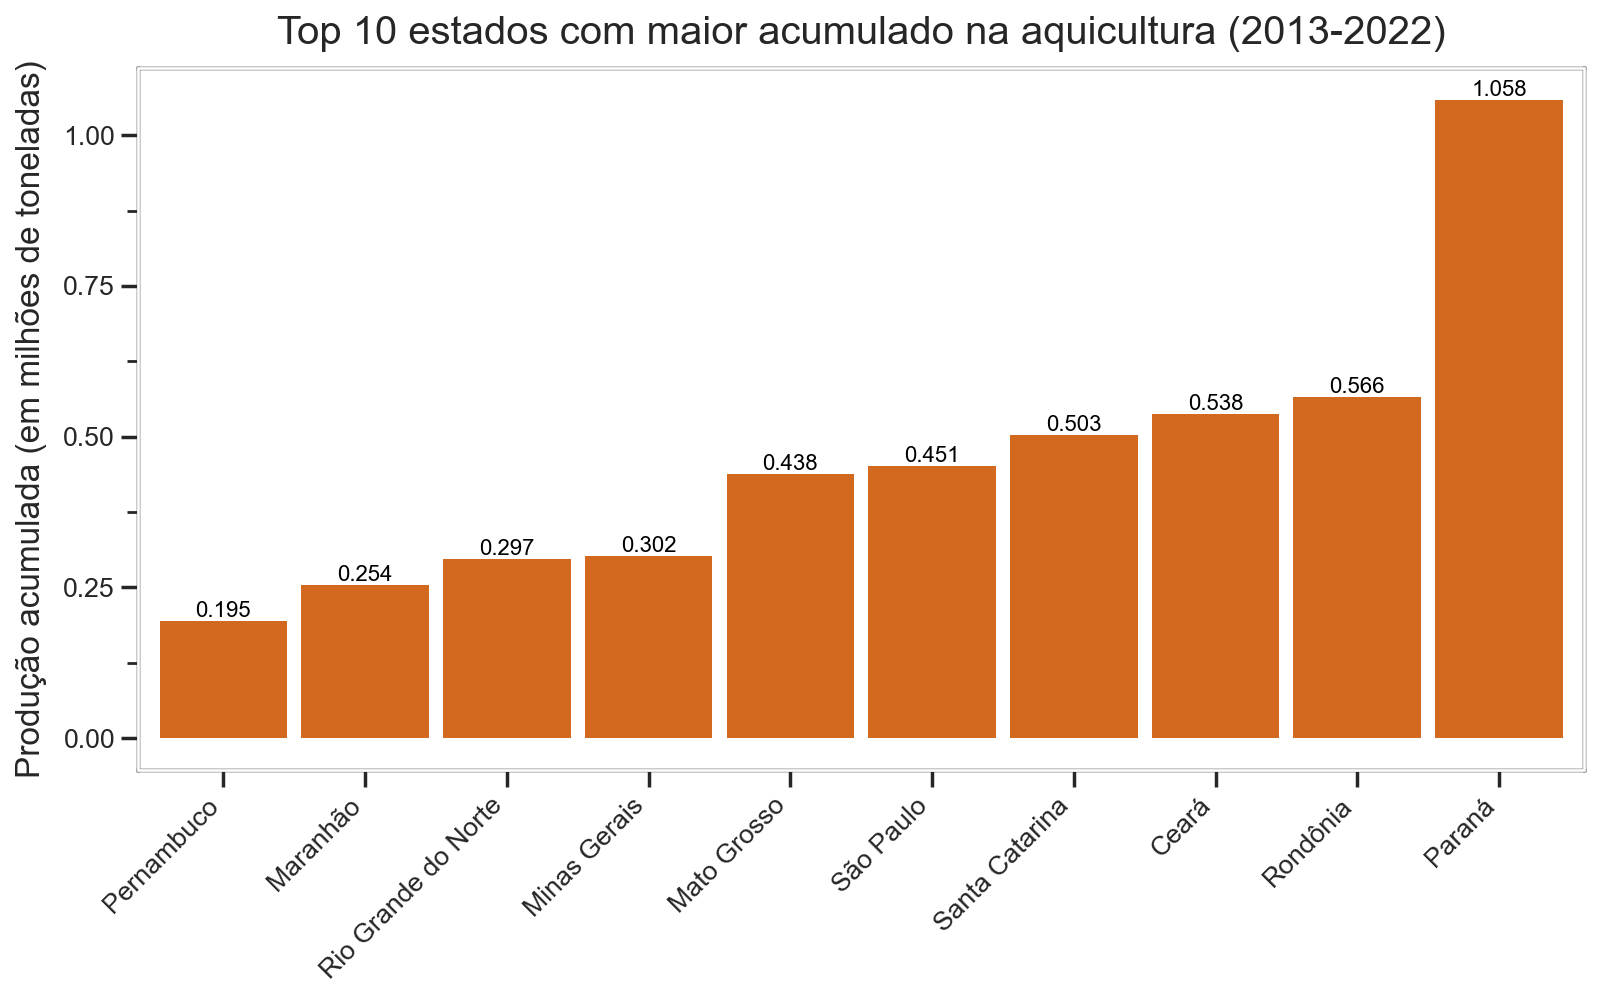

In [18]:
# Agrupa os dados por estado e calcula o total de produtos em cada estado
aquaculture_top_states = (aquaculture_df
    .groupby('nome_uf')
    .agg({'quantidade': 'sum'})
    .assign(quantidade_milhoes_toneladas=lambda x: x.quantidade / ONE_MILLION)
    .reset_index()
    .sort_values(by='quantidade_milhoes_toneladas', ascending=False)
    .head(10)
)

plot = (ggplot(aquaculture_top_states, 
	aes(x='reorder(nome_uf, quantidade_milhoes_toneladas)', y='quantidade_milhoes_toneladas'))
    + geom_bar(stat='identity', fill='chocolate')
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        panel_grid_major=element_blank(),
        figure_size=(8,5)
    )
    + geom_text(
		aes(label=aquaculture_top_states.quantidade_milhoes_toneladas.round(3)),
		va='bottom',
		size=8
	)
    + labs(
        title='Top 10 estados com maior acumulado na aquicultura (2013-2022)',
        x='',
        y='Produção acumulada (em milhões de toneladas)'
    )
)

plot.show()

O gráfico mostra os 10 estados brasileiros com maior produção acumulada na aquicultura entre 2013 e 2022, em milhões de toneladas. O **Paraná** lidera com uma produção acumulada de 1,058 milhões de toneladas, destacando-se amplamente sobre os demais estados. Rondônia e Ceará aparecem em segundo e terceiro lugar, com 0,566 e 0,538 milhões de toneladas, respectivamente.

Esses dados indicam uma concentração significativa da produção em poucos estados, com o Paraná como o principal destaque no período analisado. Esse estado parece ter uma vantagem competitiva na aquicultura, possivelmente devido a fatores como clima, infraestrutura e políticas públicas.

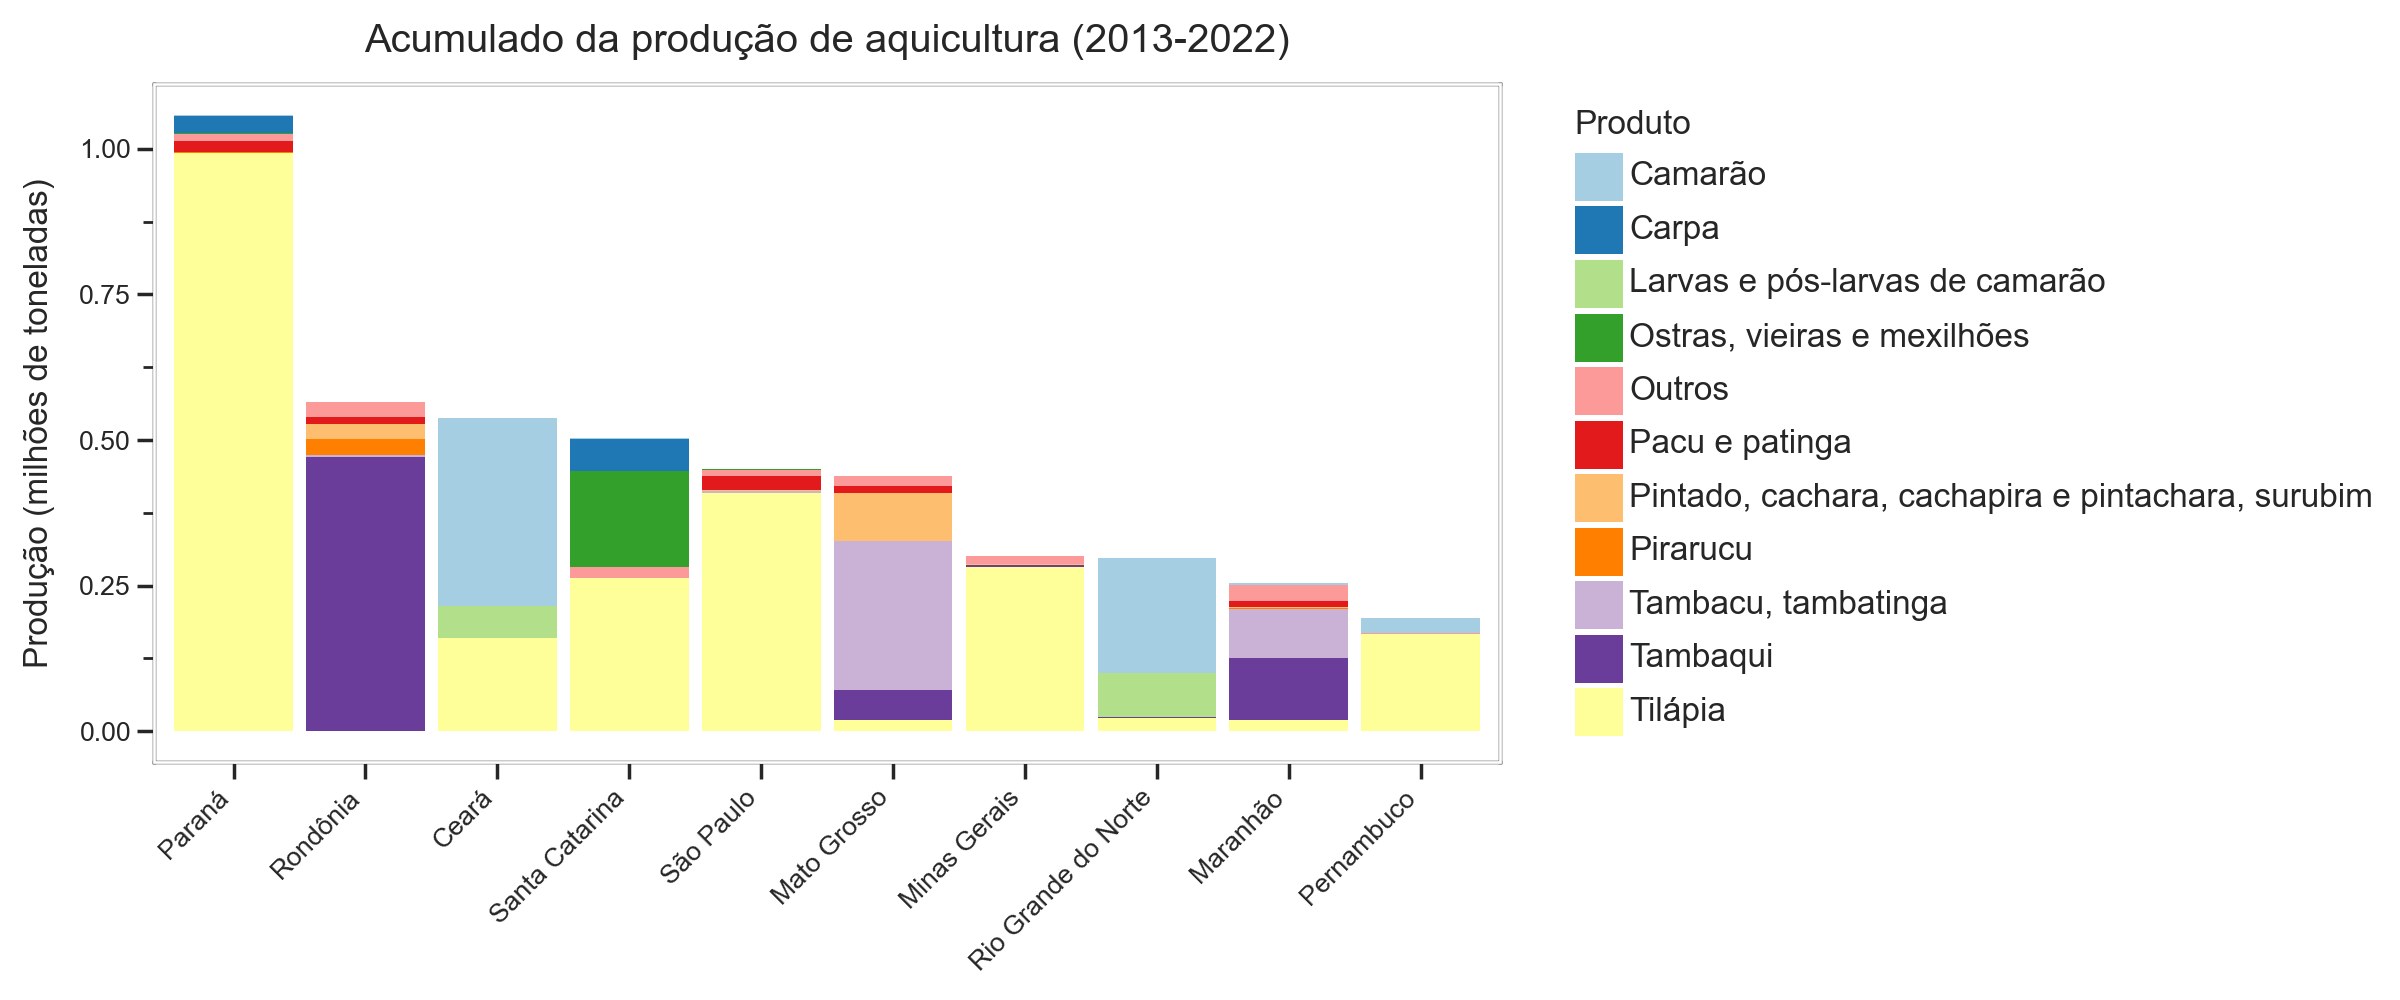

In [20]:
# Ajusta as quantidades para milhões
df = aquaculture_df.assign(quantidade_milhoes_toneladas=aquaculture_df.quantidade / ONE_MILLION)

# Filtra os 10 estados com maior produção acumulada
top_states = (
    df.groupby("nome_uf")
    .quantidade_milhoes_toneladas.sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filtra o dataframe com os estados selecionados
filtered_df = df.query("nome_uf in @top_states")

# Agrupa produtos menos relevantes como "Outros"
top_produtos = list(filtered_df
    .groupby("produto")
    .quantidade_milhoes_toneladas.sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filtra os produtos mais relevantes
filtered_df = filtered_df.assign(produto_agrupado=filtered_df.query("produto in @top_produtos").produto)

# Preenche os valores nulos com "Outros"
filtered_df = filtered_df.assign(produto_agrupado=filtered_df.produto_agrupado.fillna("Outros"))

# Ordena os estados pela produção acumulada
estado_ordem = (filtered_df
    .groupby("nome_uf")
    .quantidade_milhoes_toneladas.sum()
    .sort_values(ascending=False)
    .index
)

# Altera a coluna 'nome_uf' para categórica ordenada
filtered_df = filtered_df.assign(
    nome_uf=pd.Categorical(filtered_df.nome_uf, categories=estado_ordem, ordered=True)
)

# Agrupa os dados por estado e produto
grouped_data = (filtered_df
    .groupby(["nome_uf", "produto_agrupado"])
    .quantidade_milhoes_toneladas.sum()
    .reset_index()
)

# Plota gráfico de barras empilhadas
stacked_bar_chart = (ggplot(grouped_data, 
	aes(x="nome_uf", y="quantidade_milhoes_toneladas", fill="produto_agrupado"))
    + geom_bar(stat="identity", position="stack")
    + theme(
		axis_text_x=element_text(rotation=45, hjust=1), 
		figure_size=(12, 5),
    )
    + scale_fill_brewer(type="qual", palette="Paired")
    + labs(
        title="Acumulado da produção de aquicultura (2013-2022)",
		x="",
		y="Produção (milhões de toneladas)",
		fill="Produto"
	)
)

# Exibir o gráfico
stacked_bar_chart.show()

O gráfico mostra a composição da produção de aquicultura acumulada nos 10 estados mais produtivos do Brasil entre 2013 e 2022, destacando os principais produtos em cada estado. A **Tilápia** é o produto dominante, especialmente no Paraná, onde representa a maior parte da produção total, seguido por Santa Catarina e São Paulo. Este padrão pode ser explicado pelas condições climáticas favoráveis, disponibilidade de recursos hídricos e infraestrutura desenvolvida nesses estados para a produção de Tilápia.

O **Tambaqui**, outro produto importante, é fortemente produzido em Rondônia, com seus rios e clima quente, ideais para esta espécie. Já o **Camarão** aparece com relevância no Ceará e no Rio Grande do Norte, onde as condições costeiras e as iniciativas de aquicultura marinha favorecem sua produção.

Outros produtos, como o **Tambacu** e o **Pintado**, têm participações menores, mas significativas em estados como Mato Grosso e Minas Gerais, que possuem tradição em aquicultura de espécies de água doce.

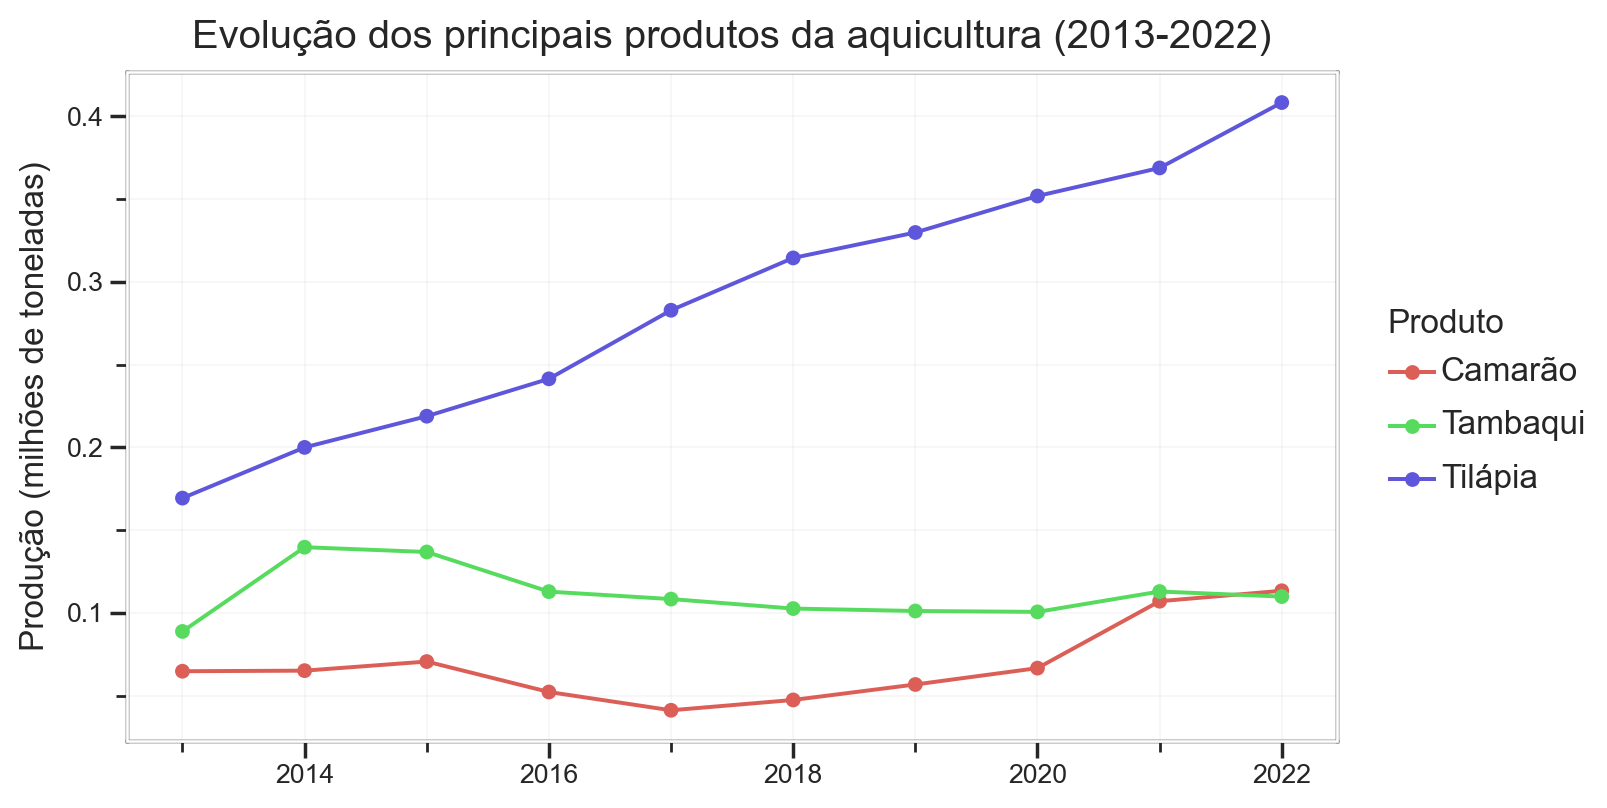

In [21]:
top_3_products = ["Tilápia", "Tambaqui", "Camarão"]
filtered_df_temporal = aquaculture_df.query("produto in @top_3_products")

# Agrupa por ano e produto para calcular a soma da quantidade (em milhões de toneladas)
temporal_data = (filtered_df_temporal
    .groupby(["ano", "produto"])
    .agg({"quantidade": "sum"})
    .assign(quantidade_milhoes_toneladas=lambda x: x / ONE_MILLION)
    .reset_index()
)

temporal_growth_chart = (
    ggplot(temporal_data, aes(x="ano", y="quantidade_milhoes_toneladas", color="produto"))
    + geom_line(size=0.8)
    + geom_point(size=2)
    + scale_x_continuous(
        breaks=range(2012, 2024, 2),                         # Anos de 2 em 2
        labels=[str(year) for year in range(2012, 2024, 2)]  # Exibir como inteiros
    )
    + theme(
		figure_size=(8, 4), 
		panel_grid=element_line(size=0.1)
    )
    + ggtitle("Evolução dos principais produtos da aquicultura (2013-2022)")
    + labs(
		x="",
		y="Produção (milhões de toneladas)",
		color="Produto"
	)
)

temporal_growth_chart.draw()

No período analisado, a produção de tilápia no Brasil cresceu significativamente, mais que dobrando sua produção de 2013 a 2022. Isso pode se dar por diversos fatores, como a demanda crescente por pescado e a eficiência produtiva alcançada pelos produtores.

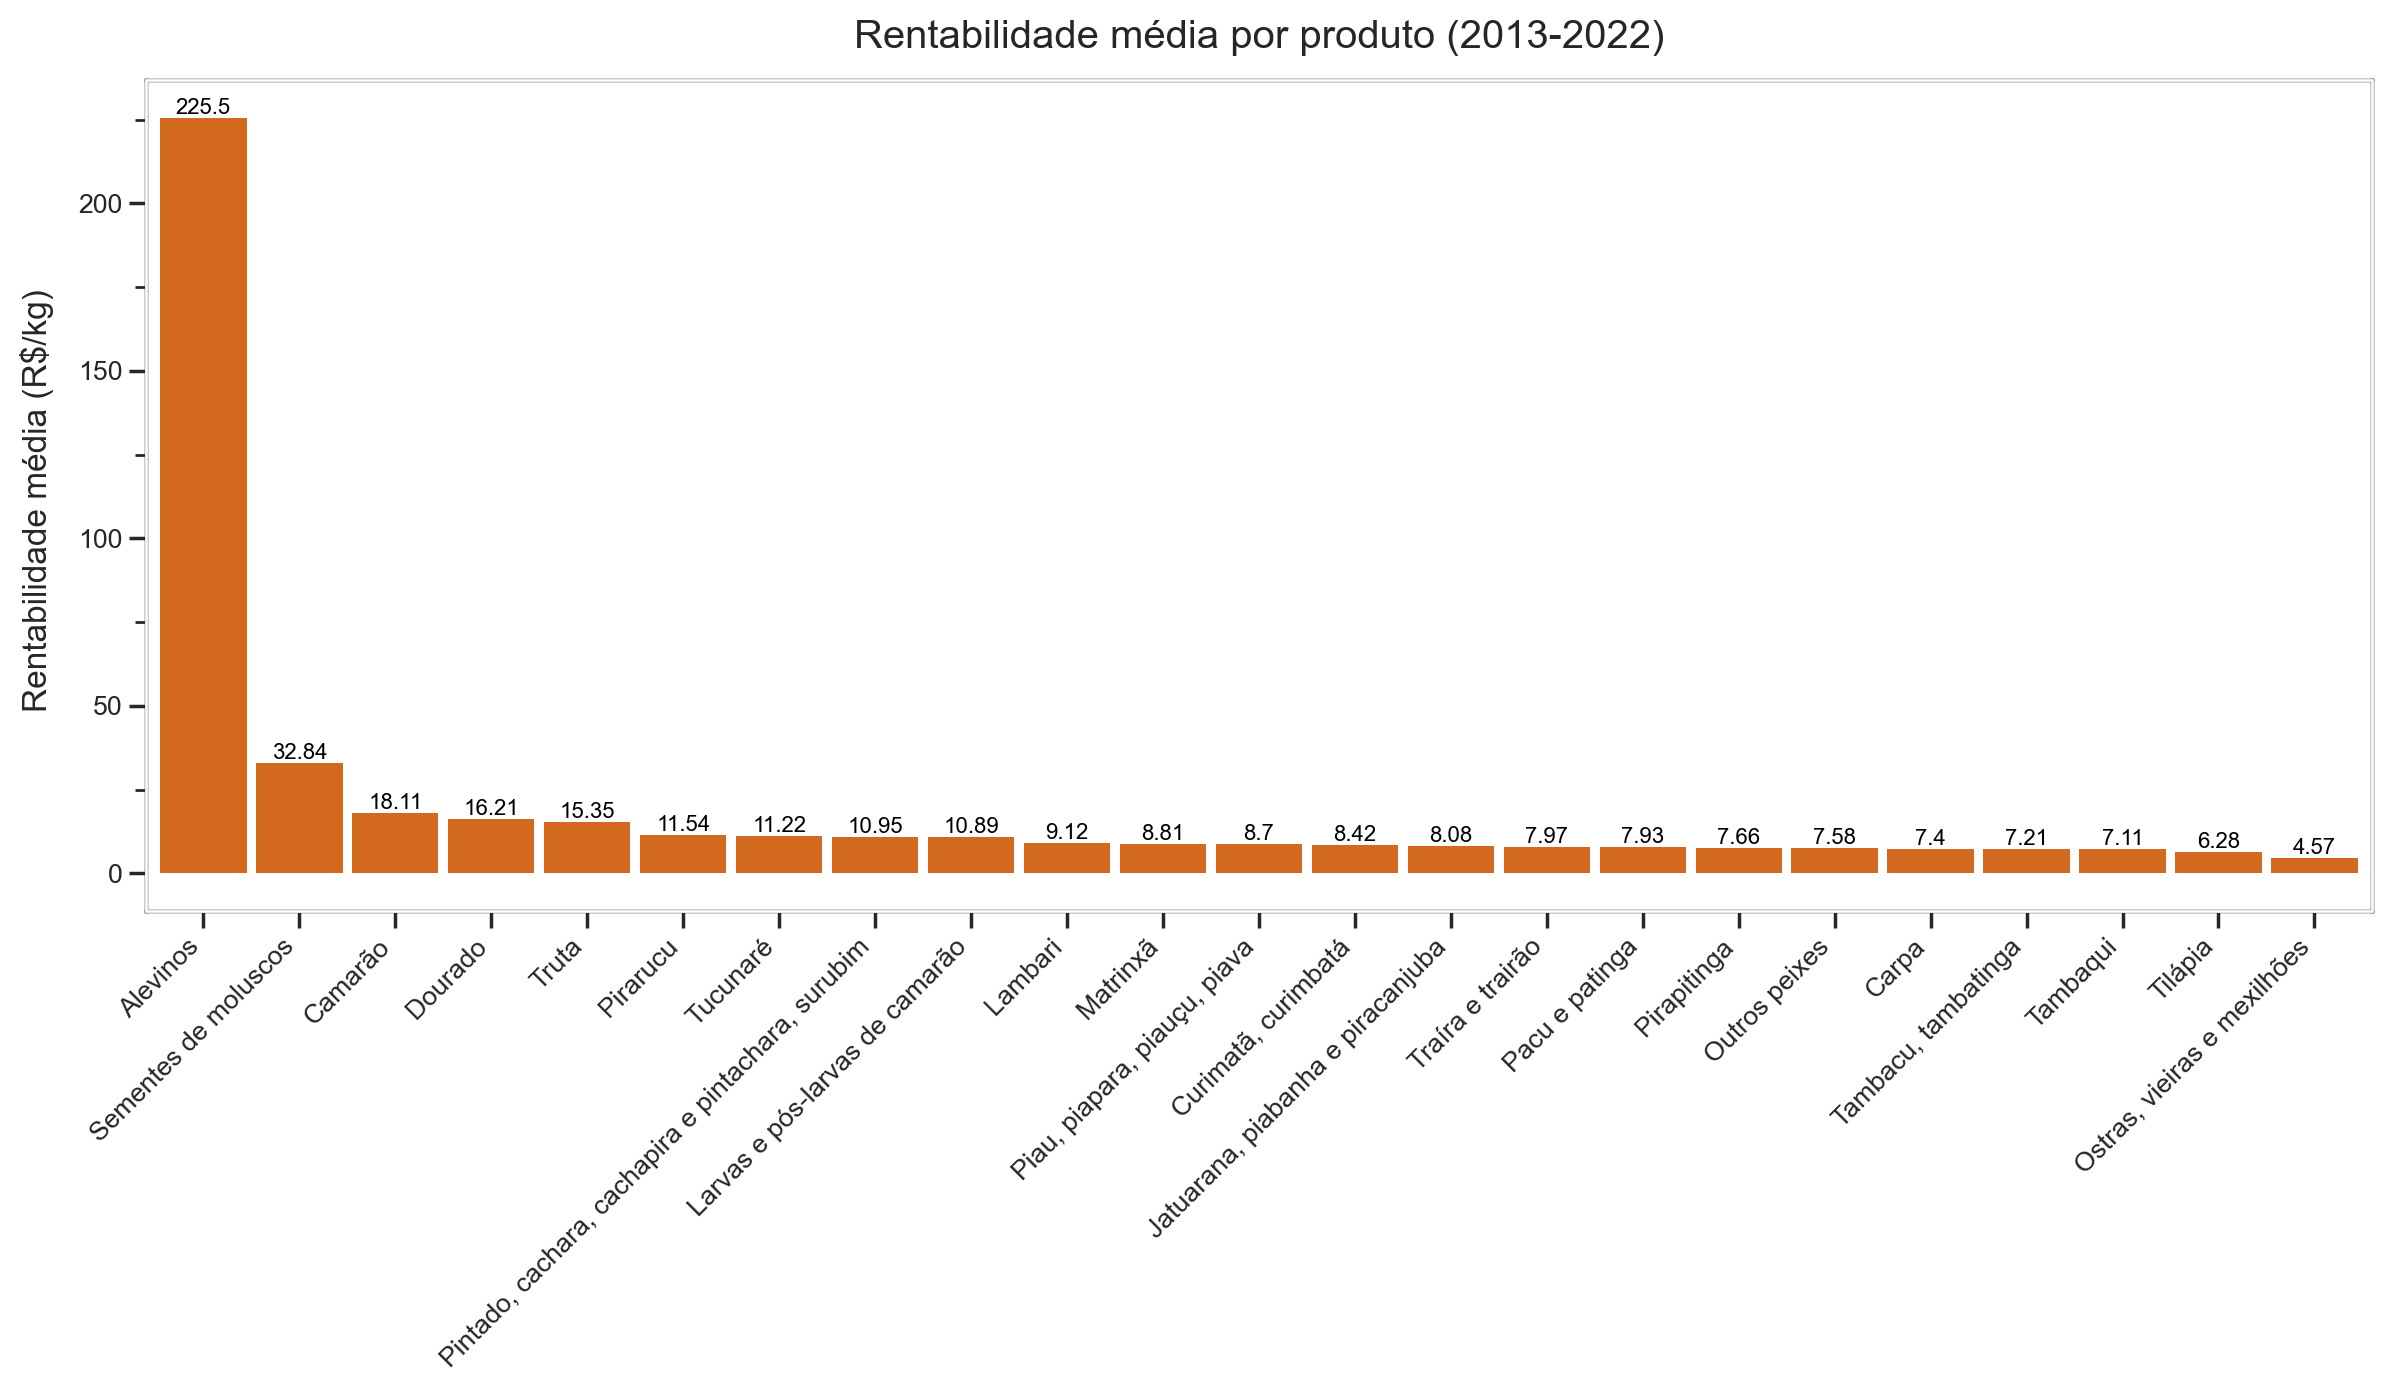

In [22]:
# Calcula o valor total e quantidade total por produto
rentabilidade_produto = (aquaculture_df
	.groupby("produto")
    .agg(
        valor_total=("valor", "sum"),           # milhões de R$
        quantidade_total=("quantidade", "sum")  # toneladas
    )
    .assign(rentabilidade=lambda _: (_.valor_total * ONE_MILLION) / (_.quantidade_total * ONE_TONNE)) # R$/kg
    .sort_values("rentabilidade", ascending=False)  # Ordena por rentabilidade
    .reset_index()
)

# Ordena os produtos do mais para o menos rentável
bar_chart_data = rentabilidade_produto.assign(
    produto=pd.Categorical(
        rentabilidade_produto.produto,
        categories=rentabilidade_produto.sort_values("rentabilidade", ascending=False).produto,
        ordered=True
    )
)

rentabilidade_chart = (
    ggplot(bar_chart_data, aes(x="produto", y="rentabilidade"))
    + geom_bar(stat="identity", fill="chocolate")
    + geom_text(
		aes(label=round(bar_chart_data.rentabilidade, 2)), va="bottom", size=8
	)
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 7))
    + labs(
		x="", 
		y="Rentabilidade média (R$/kg) ",
		title="Rentabilidade média por produto (2013-2022)"
    )
)

rentabilidade_chart.draw()

O gráfico apresenta a rentabilidade média por produto na aquicultura brasileira entre 2013 e 2022, em reais por quilograma (R$/kg). Destaca-se que os **alevinos** possuem a maior rentabilidade, com R$ 225,50 por quilograma, muito acima de qualquer outro produto. Isso reflete o fato de serem insumos altamente especializados, geralmente destinados à reprodução e criação de peixes em sistemas de aquicultura.

Em segundo lugar aparecem as **sementes de moluscos**, com R$ 32,84/kg, também relacionadas a um segmento mais nichado e de maior valor agregado. O **camarão** (R$ 18,11/kg) e o **dourado** (R$ 16,21/kg) se destacam como os produtos consumíveis mais rentáveis, refletindo sua alta demanda no mercado e preços premium.

Produtos amplamente produzidos como a **tilápia** (R$ 6,28/kg) e o **tambaqui** (R$ 7,11/kg) apresentam menor rentabilidade média, indicando que sua competitividade está baseada em grandes volumes de produção, e não em valores elevados por quilograma.

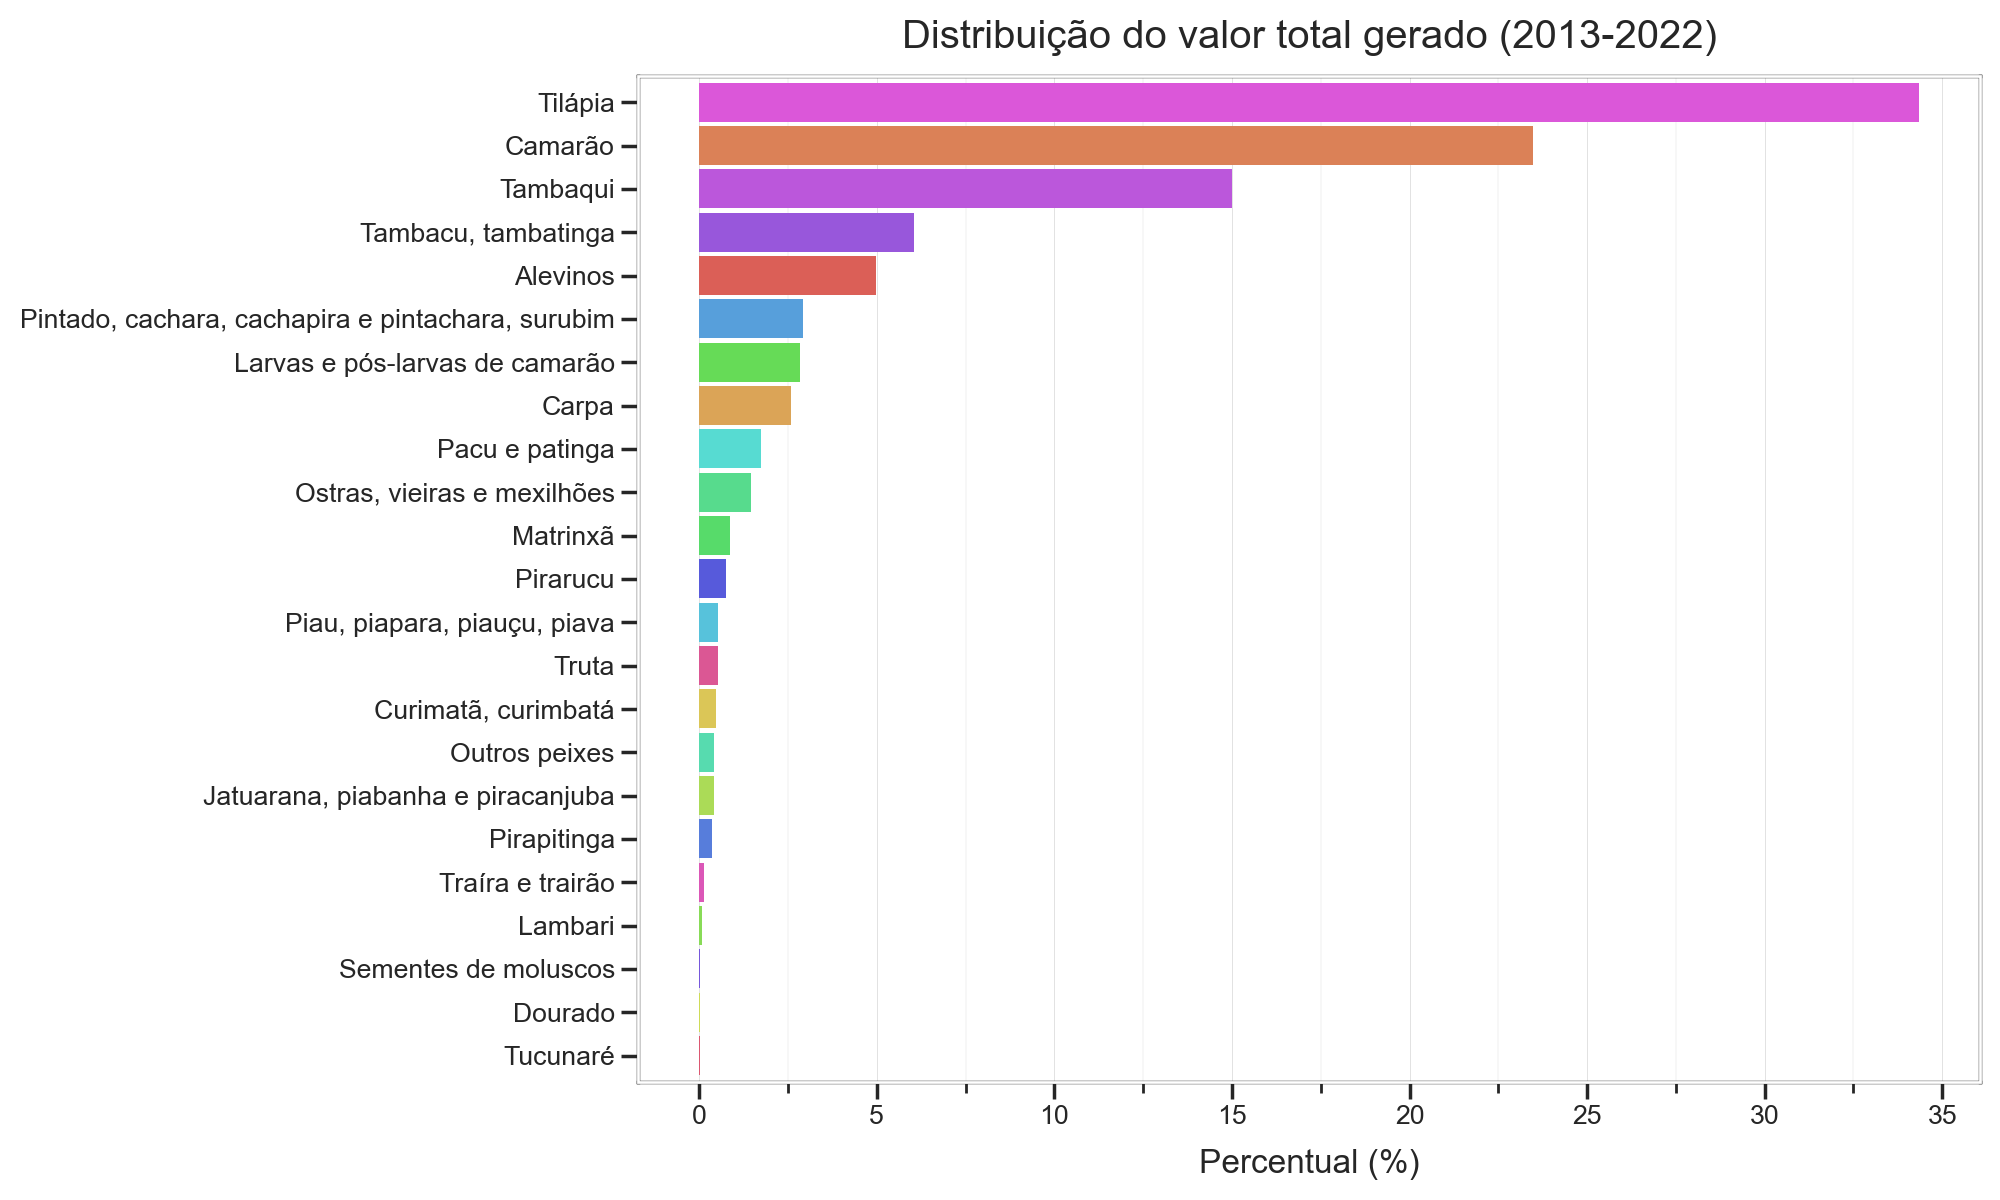

In [23]:
# Converte o valor para reais e calcular o percentual por produto
valor_total_produto = (aquaculture_df
	.groupby("produto")
    .valor.sum()
    .reset_index()
    .assign(valor_real=lambda x: x.valor * ONE_MILLION)  # Converte para reais
    .assign(percentual=lambda x: (x.valor_real / x.valor_real.sum()) * 100)
    .sort_values("percentual", ascending=False)
)

bar_chart = (
    ggplot(valor_total_produto, aes(x="reorder(produto, percentual)", y="percentual", fill="produto"))
    + geom_bar(stat="identity")
    + coord_flip()
    + scale_y_continuous(
        breaks=range(0, 60, 5),  # Anos de 5 em 5
    )
    + theme(
		legend_position="none", # Remove a legenda autogerada
		figure_size=(10, 6),
		panel_grid_major_x=element_line(size=0.2),
		panel_grid_minor_x=element_line(size=0.1),
    )
    + labs(
		title="Distribuição do valor total gerado (2013-2022)",
		x="",
		y="Percentual (%)"
	)
)

bar_chart.draw()

O gráfico apresenta a distribuição percentual do valor total gerado por diferentes produtos da aquicultura brasileira entre 2013 e 2022. A **Tilápia** é a líder absoluta, gerando mais de 30% do valor total, o que reflete sua dominância tanto em volume produzido quanto em sua relevância comercial. O **Camarão** aparece em segundo lugar, representando uma significativa parcela de cerca de 25% do valor total, seguido pelo **Tambaqui**, que contribui com pouco mais de 15%. Produtos como o **Tambacu**, **Alevinos** e **Pintado, cachara, cachapira e pintachara** possuem contribuições menores, mas ainda relevantes, enquanto outros produtos, como a **Carpa** e as **Ostras, vieiras e mexilhões**, têm percentuais mais modestos. Este padrão sugere que o mercado é altamente concentrado em algumas espécies principais, com produtos como Tilápia e Camarão dominando o setor devido à alta demanda no mercado interno e potencial exportador. Produtos com menor participação no valor total podem ser destinados a nichos específicos ou apresentar menor volume de produção.

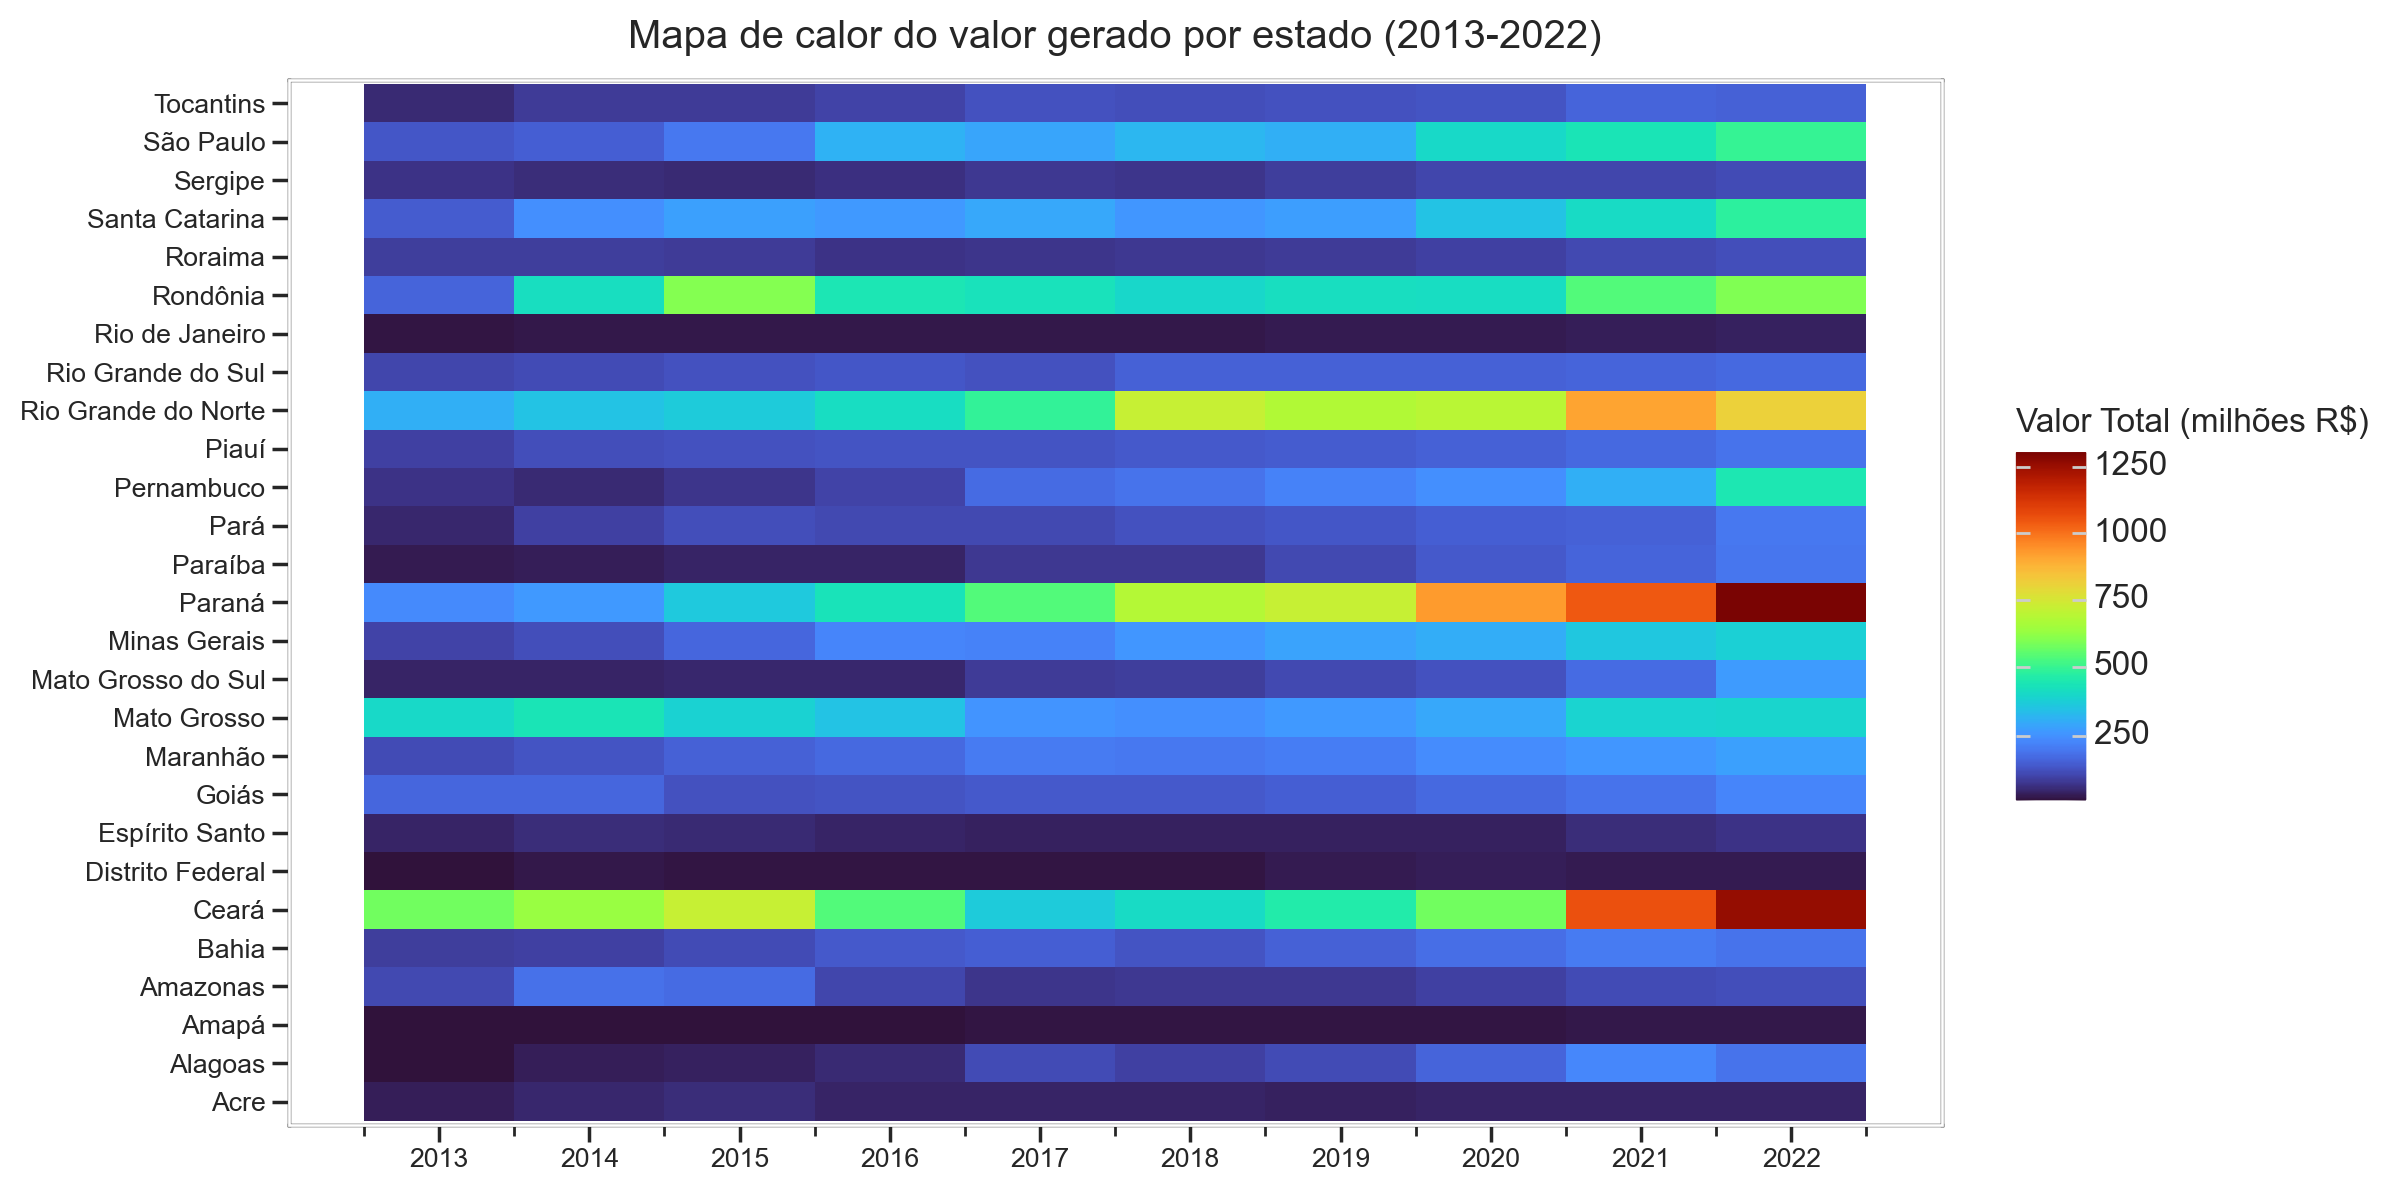

In [24]:
# Calcula o total por ano e estado
heatmap_data = (aquaculture_df
	.groupby(["nome_uf", "ano"])
	.agg(valor_total=("valor", "sum"))
	.reset_index()
)

heatmap_plot = (ggplot(heatmap_data, 
	aes(x="ano", y="nome_uf", fill="valor_total"))
    + geom_tile() # Cria um heatmap
    + scale_fill_gradientn(colors=[cm.turbo(i) for i in range(256)])
    + scale_x_continuous(
        breaks=sorted(heatmap_data.ano.unique()),
        labels=[str(year) for year in sorted(heatmap_data.ano.unique())]
    )
    + theme(
        figure_size=(12, 6),
	)
	+ labs(
		x="",
		y="",
		fill="Valor Total (milhões R$)",
		title="Mapa de calor do valor gerado por estado (2013-2022)"
	)
)

heatmap_plot.draw()

O gráfico apresenta um mapa de calor mostrando o valor total gerado pela aquicultura, em milhões de reais, por estado e ano, entre 2013 e 2022. Estados como o **Ceará**, **Paraná**, **Rondônia** e **Rio Grande do Norte** aparecem como os principais destaques, com valores elevados em períodos específicos. O **Paraná**, principalmente, mostra uma crescente evolução ao longo dos anos, denotando um forte crescimento na produção de aquicultura.

O **Ceará** também se destaca com contribuições expressivas ao longo de quase todo o período analisado, o que pode ser atribuído à produção de Camarão, muito relevante no estado. Rondônia apresenta uma constância mais significativa, destacando-se pela produção de Tambaqui.

Outros estados, como **Santa Catarina** e **São Paulo**, possuem contribuições mais modestas, mas consistentes, refletindo sua diversidade na produção de espécies aquáticas.

### Prevendo a produção de aquicultura

In [31]:
df = (
	aquaculture_df
	.query("produto == 'Tilápia'")
	.groupby(["nome_regiao", "ano"])
	.agg(
		quantidade_total=("quantidade", "sum"),
		valor_total=("valor", "sum")
    )
    .reset_index()
    .assign(valor_quilo=lambda x: (1000 * x.valor_total) / x.quantidade_total)
    .assign(regiao = lambda _: pd.Categorical(_.nome_regiao, categories=_.nome_regiao.unique(), ordered=False))
    .drop(columns=["valor_total", "nome_regiao"])
)

df.head()

,ano,quantidade_total,valor_quilo,regiao
0,2013,11524.425,4.627997,Centro-Oeste
1,2014,15477.445,4.584219,Centro-Oeste
2,2015,17785.914,5.000305,Centro-Oeste
3,2016,15620.673,5.318977,Centro-Oeste
4,2017,21473.234,5.340602,Centro-Oeste


In [32]:
lin_reg = smf.ols("valor_quilo ~ ano + quantidade_total + regiao", df).fit()

lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            valor_quilo   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     58.52
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           4.37e-19
Time:                        23:08:54   Log-Likelihood:                -46.538
No. Observations:                  50   AIC:                             107.1
Df Residuals:                      43   BIC:                             120.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -978.2705     90.982    -10.752      0.000   -1161.753    -794.787
regiao[T.Nordeste]     1.9032      0.362      5.251      0.000       1.172       2.634
regiao[T.Norte]        2.6890      0.329      8.185      0.000       2.026       3.351
regiao[T.Sudeste]      0.8168      0.426      1.918      0.062      -0.042       1.676
regiao[T.Sul]          0.6950      0.696      0.999      0.323      -0.708       2.098
ano                    0.4879      0.045     10.807      0.000       0.397       0.579
quantidade_total   -1.071e-05      6e-06     -1.785      0.081   -2.28e-05    1.39e-06
==============================================================================
Omnibus:                        3.061   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.216   Jarque-Bera (JB):                2.291
Skew:                           0.219   Prob(JB):                        0.318
Kurtosis:                       3.952   Cond. No.                     7.38e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
training, test = train_test_split(df, test_size=0.5, random_state=42)

lin_reg = smf.ols("valor_quilo ~ ano + np.log(quantidade_total) + regiao", training).fit()

print("R^2 = ", lin_reg.rsquared)

y_hat = lin_reg.predict(test)

RMSE = np.sqrt(mean_squared_error(np.exp(y_hat), test.valor_quilo))

np.round(RMSE, 2)

R^2 =  0.9286294447137394


np.float64(3836.84)

## Efetivo de rebanhos

Os rebanhos brasileiros são um dos maiores símbolos da força e diversidade do agronegócio nacional: bovinos, suínos, equinos, caprinos, bubalinos e até aves como codornas e galinhas compõem esse vasto cenário, cada um com sua importância econômica, social e cultural. O Brasil, sendo um dos maiores produtores e exportadores de carne e derivados do mundo, destaca-se pelo papel estratégico de seus rebanhos no comércio internacional.

### Entendendo a base de dados


A base de dados, originalmente, contém as seguintes colunas:


| Nome da Variável     | Significado                                   | Tipo de Dado |
|----------------------|-----------------------------------------------|--------------|
| `ano`                | Ano de referência da informação               | Numérico     |
| `id_municipio`       | Código IBGE do município                      | Numérico     |
| `sigla_uf`           | Sigla da Unidade da Federação                 | Texto        |
| `tipo_rebanho`       | Tipo de rebanho                               | Texto        |
| `quantidade`         | Quantidade da produção (kg)                   | Numérico     |

### Análise Exploratória

In [34]:
flock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368144 entries, 0 to 1368143
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ano           1368144 non-null  int64 
 1   sigla_uf      1368144 non-null  object
 2   id_municipio  1368144 non-null  int64 
 3   tipo_rebanho  1368144 non-null  object
 4   quantidade    1368144 non-null  int64 
 5   municipio     1368144 non-null  object
 6   nome_uf       1368144 non-null  object
 7   nome_regiao   1368144 non-null  object
 8   centroide     1368144 non-null  object
dtypes: int64(3), object(6)
memory usage: 93.9+ MB


In [35]:
flock_df.head(1)

,ano,sigla_uf,id_municipio,tipo_rebanho,quantidade,municipio,nome_uf,nome_regiao,centroide
0,1978,RO,1100106,Bovino,12943,Guajará-Mirim,Rondônia,Norte,POINT(-64.537710733004 -11.3055098790143)


In [36]:
# Valores nulos
flock_df.isnull().sum().sort_values(ascending=False)

ano             0
sigla_uf        0
id_municipio    0
tipo_rebanho    0
quantidade      0
municipio       0
nome_uf         0
nome_regiao     0
centroide       0
dtype: int64

In [37]:
# Anos disponíveis (ordenado)
flock_df.ano.sort_values().unique()

array([1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022])

In [38]:
# Tipos de rebanhos
flock_df.tipo_rebanho.unique()

array(['Bovino', 'Equino', 'Caprino', 'Bubalino', 'Codornas',
       'Suíno - total', 'Galináceos - galinhas',
       'Suíno - matrizes de suínos'], dtype=object)

Apenas para manter uma congruência com os dados de aquicultura, vamos abordar aqui os anos a partir de 2013.

In [39]:
# Removendo anos anteriores a 2013
flock_df.query("ano >= 2013", inplace=True)

#### Total de rebanhos produzidos no Brasil

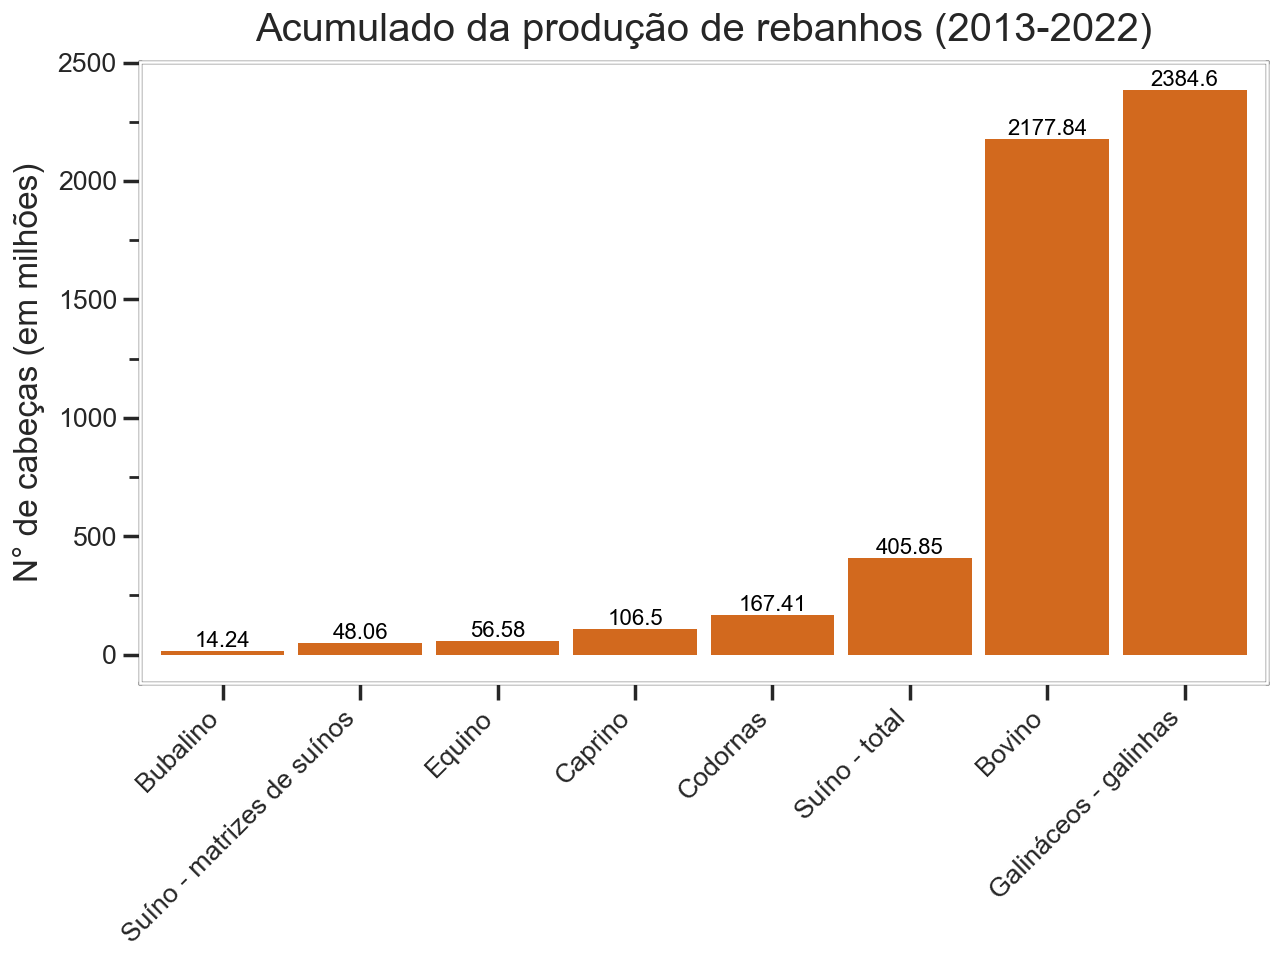

In [40]:
# Agrupa por 'tipo_rebanho' e soma as quantidades
flocks_by_type = (flock_df
	.groupby('tipo_rebanho')
	.agg({'quantidade': 'sum'})
	.assign(quantidade_milhoes = lambda _: _.quantidade / ONE_MILLION)
	.reset_index())

plot = (ggplot(flocks_by_type,
	aes(x='reorder(tipo_rebanho, quantidade_milhoes)', y='quantidade_milhoes'))
    + geom_bar(stat='identity', fill='chocolate')
    + geom_text(
        aes(label=flocks_by_type.quantidade_milhoes.round(2)),
        va='bottom',
        size=8
    )
    + theme(
		axis_text_x=element_text(rotation=45, hjust=1),
        panel_grid_major=element_blank(),
    )
    + labs(
		title='Acumulado da produção de rebanhos (2013-2022)',
		x='',
		y='N° de cabeças (em milhões)'
    )
)

plot.show()

O tipo de rebanho **Galináceos - galinhas** possui a maior quantidade, com quase 2.4 bilhões somados, seguido da classe dos bovinos, com valor muito próximo. Isso indica que galináceos representam uma parte significativa da produção total de rebanhos, possivelmente por serem um alimento básico e com alta demanda no mercado, enquanto que a produção de bovinos geralmente está associada tanto ao consumo de carne quanto à produção de leite, o que pode justificar o seu volume elevado.

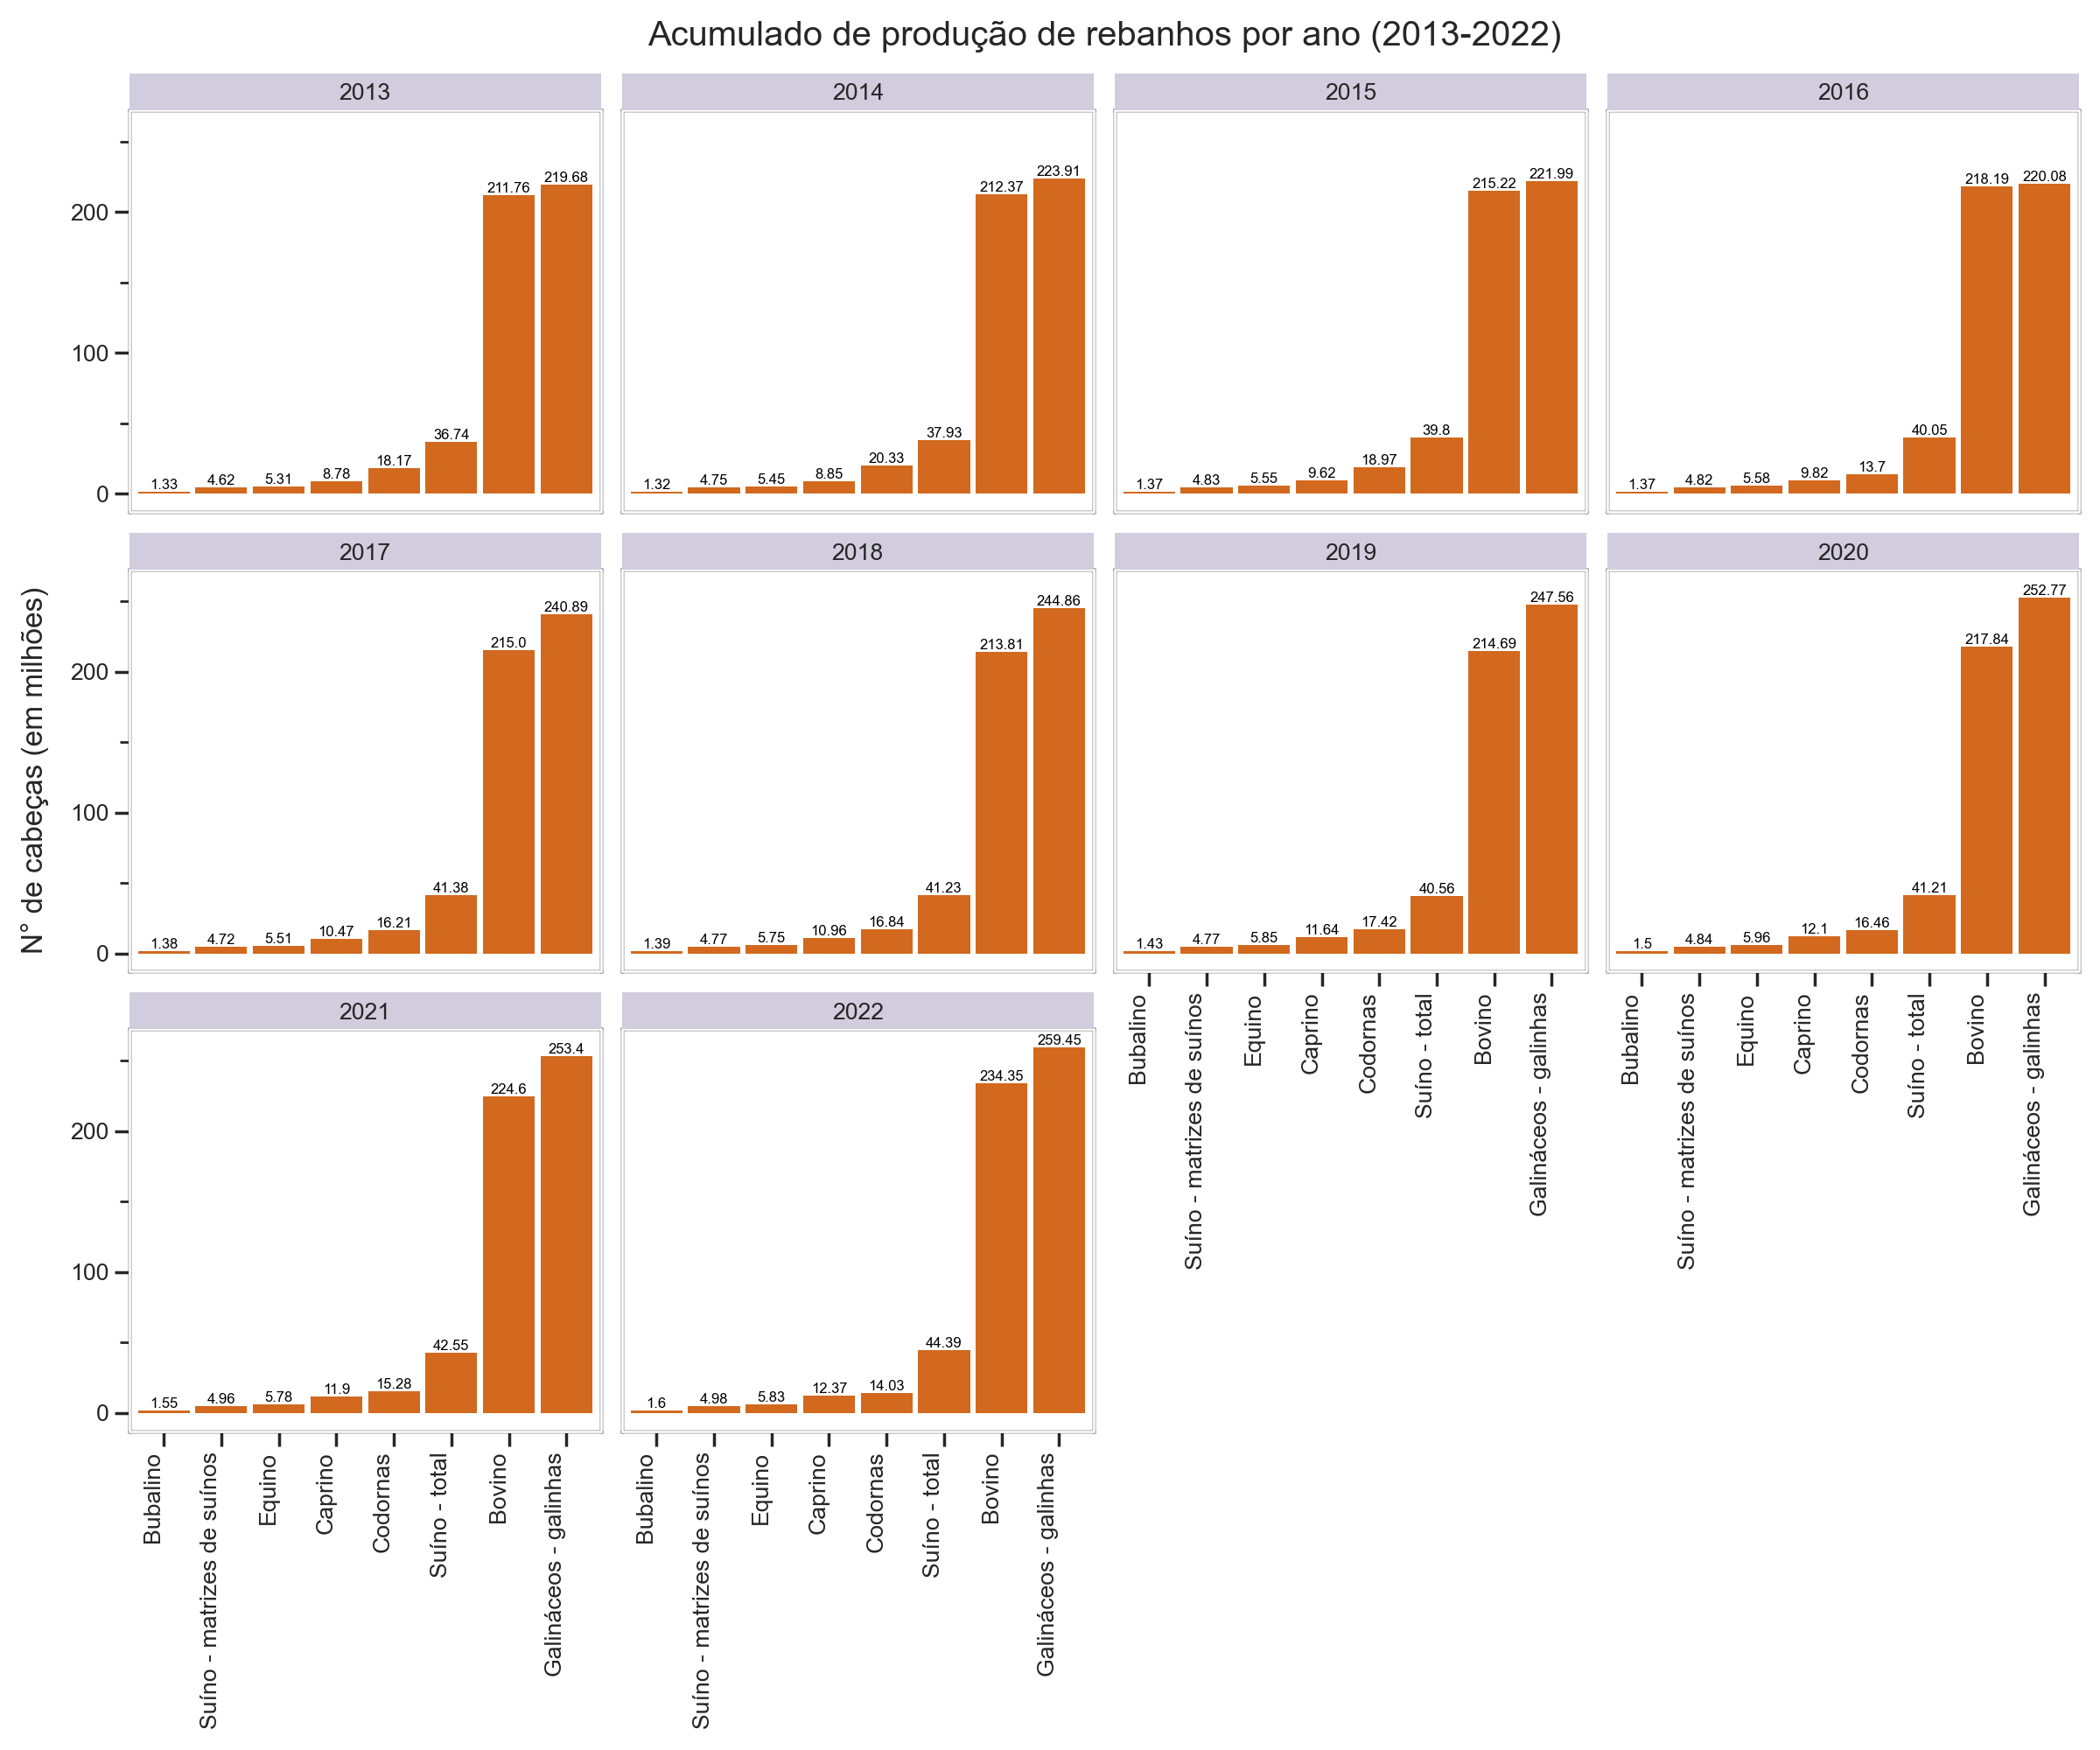

In [41]:
# Agrupa os dados por ano e tipo de rebanho
flocks_by_type_year = (flock_df
    .groupby(['ano', 'tipo_rebanho'])
    .agg({'quantidade': 'sum'})
    .assign(quantidade_milhoes=lambda _: _.quantidade / ONE_MILLION)
    .reset_index()
)

plot = (ggplot(flocks_by_type_year,
	aes(x='reorder(tipo_rebanho, quantidade_milhoes)', y='quantidade_milhoes'))
    + geom_bar(stat='identity', fill='chocolate')
    + theme(
        axis_text_x=element_text(rotation=90, hjust=1),
        panel_grid_major=element_blank(),
        figure_size=(12, 10)
    )
    + geom_text(
        aes(label=flocks_by_type_year.quantidade_milhoes.round(2)),
        va='bottom',
        size=6
    )
    + facet_wrap('~ano', ncol=4) # Cria um gráfico para cada ano
    + labs(
        title='Acumulado de produção de rebanhos por ano (2013-2022)',
        x='',
        y='N° de cabeças (em milhões)'
    )
)

plot.show()

O gráfico acima mostra o mesmo comportamento observado ao longo de todo o período, alta produção de galináceos e bovinos, seguido de suínos e galinhas. No geral, a classe de **Bovino** e **Galináceos - galinhas** são as que mais se destacam, com produção sempre em destaque em relação às demais.

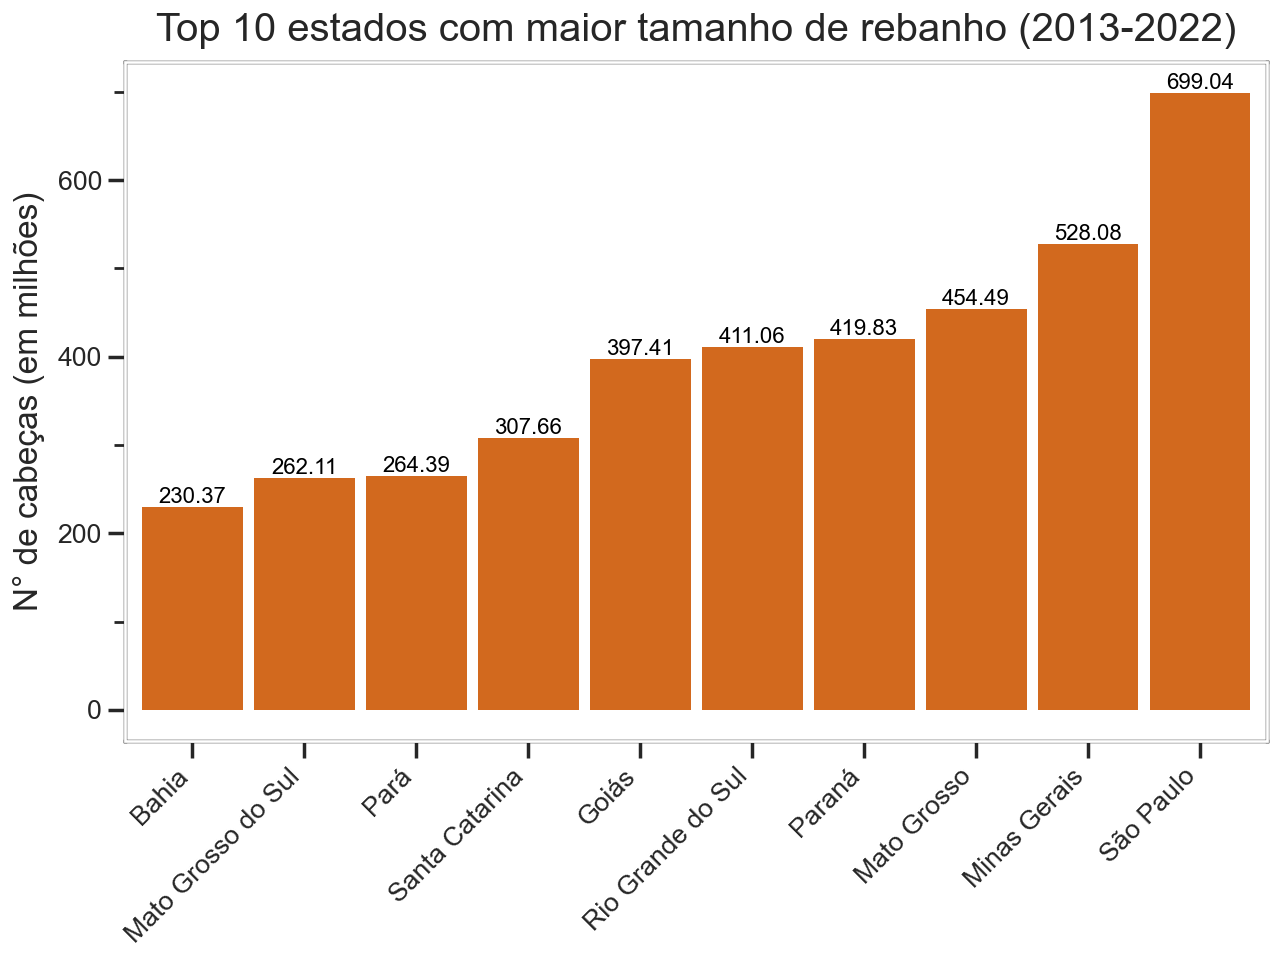

In [42]:
# Agrupa os dados por estado e calcula o total de rebanhos em cada estado
flock_top_states = (flock_df
    .groupby('nome_uf')
    .agg({'quantidade': 'sum'})
    .assign(quantidade_milhoes=lambda _: _.quantidade / ONE_MILLION)
    .reset_index()
    .sort_values(by='quantidade_milhoes', ascending=False)
    .head(10)
)

plot = (
    ggplot(flock_top_states, aes(x='reorder(nome_uf, quantidade_milhoes)', y='quantidade_milhoes'))
    + geom_bar(stat='identity', fill='chocolate')
    + geom_text(
		aes(label=flock_top_states.quantidade_milhoes.round(2)),
		va='bottom',
		size=8
	)
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        panel_grid_major=element_blank(),
    )
    + labs(
        title='Top 10 estados com maior tamanho de rebanho (2013-2022)',
        x='',
        y='N° de cabeças (em milhões)'
    )
)

plot.show()

Este gráfico exibe os 10 estados brasileiros com o maior tamanho de rebanho ao longo do período de 2013 a 2022. O estado de **São Paulo** se destaca significativamente, liderando a produção de rebanhos com uma diferença visível em relação aos outros estados. 

**Minas Gerais**, **Mato Grosso** e **Paraná** também aparecem com grandes quantidades de rebanho. São estados com bases fortes economicamente na agropecuária, com vastas áreas de pastagem e clima propício. **Goiás** e **Rio Grande do Sul**, também se destacam na produção de rebanhos. Esses estados têm uma tradição pecuária forte, com clima favorável para a criação de animais.

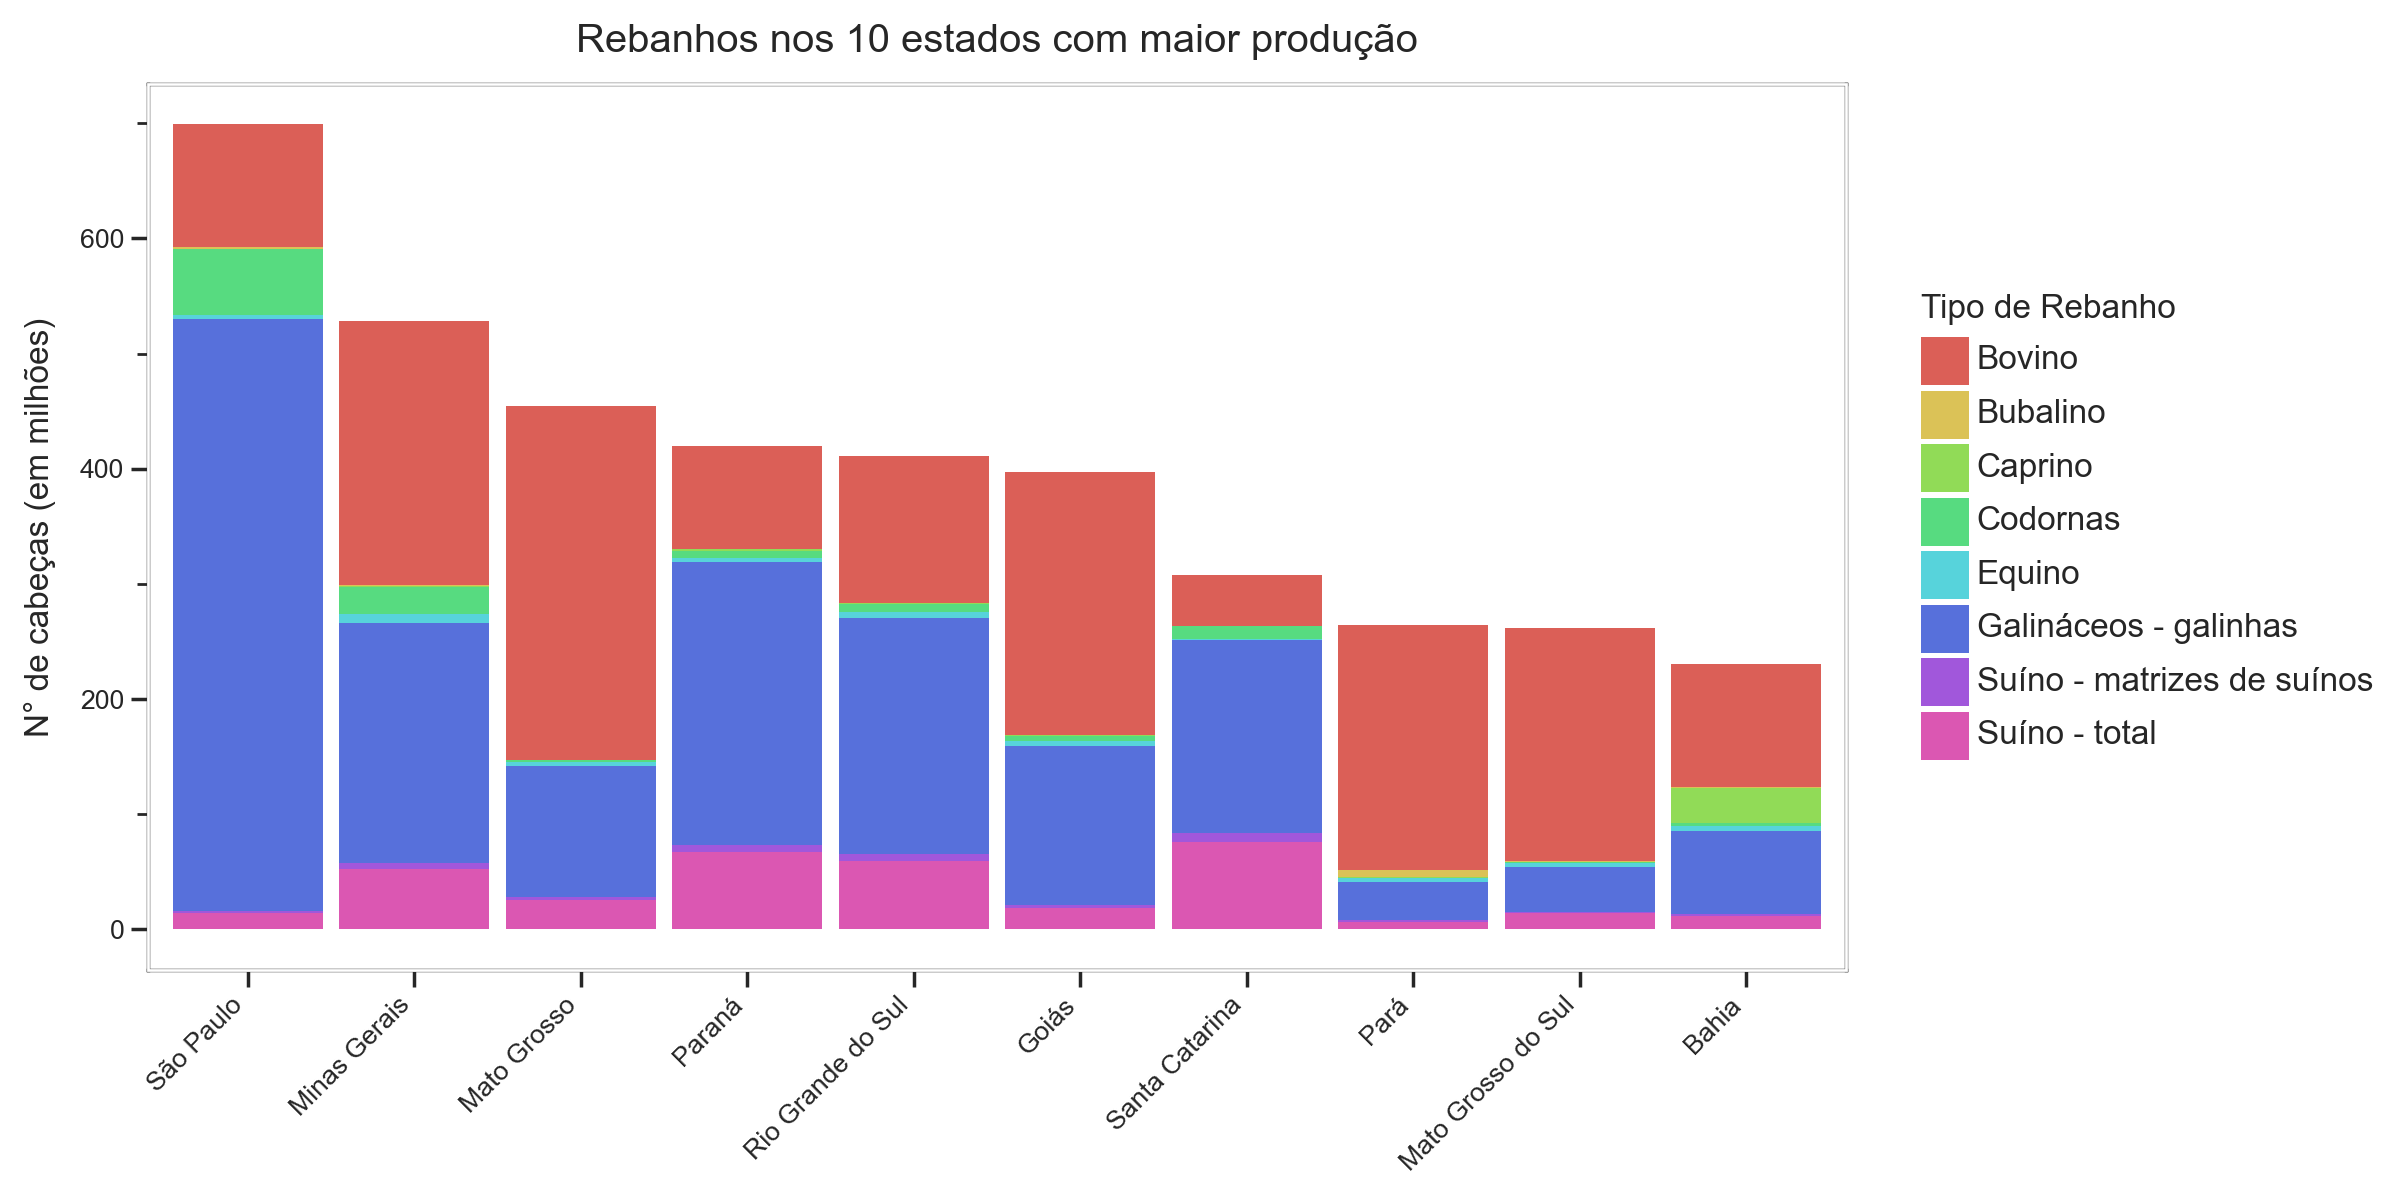

In [43]:
# Agrupa por estado e tipo de rebanho, somando as quantidades
df_grouped = (flock_df
    .groupby(["nome_uf", "tipo_rebanho"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()
    .assign(quantidade_milhoes=lambda _: _.quantidade / ONE_MILLION)
)

# Calcula o total de rebanho para cada estado e ordena
state_totals = (df_grouped
    .groupby("nome_uf")
    .agg(total_estado=("quantidade_milhoes", "sum"))
    .sort_values("total_estado", ascending=False)
    .reset_index()
    .head(10)
)

# Reordena os estados no df principal com base no total
df_grouped = (df_grouped
	.merge(state_totals, on="nome_uf")
    .assign(nome_uf=lambda _: pd.Categorical(_.nome_uf, categories=state_totals.nome_uf, ordered=True)    )
)

plot = (
    ggplot(df_grouped, aes(x="nome_uf", y="quantidade_milhoes", fill="tipo_rebanho"))
    + geom_bar(stat="identity")
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(12, 6),
        panel_grid_major=element_blank()
    )
    + labs(
        title="Rebanhos nos 10 estados com maior produção",
        x="",
        y="N° de cabeças (em milhões)",
        fill="Tipo de Rebanho"
    )
)

plot.show()

O gráfico mostra a distribuição dos tipos de rebanho nos 10 estados brasileiros com maior produção total ao longo do período de 2013 a 2022. Observa-se que o estado de São Paulo possui o maior n° de cabeças acumulado, com um destaque significativo para o rebanho de **Galináceos - galinhas**, que representa a maior parte da produção de rebanho do estado. **Minas Gerais** possui uma distribuição mais equilibrada, porém elevada, entre **Galináceos - galinhas** e **Bovinos**.

Nos estados de **Mato Grosso**, **Goiás** e **Mato Grosso do Sul**, o rebanho bovino representa a maior proporção. Isso reflete a especialização da região Centro-Oeste na pecuária bovina. **Mato Grosso**, em particular, é conhecido por sua forte atuação na pecuária de corte, atendendo tanto ao mercado interno quanto ao externo, o que justifica o destaque do rebanho bovino.

Dos 10 maiores rebanhos do país, nota-se também como o estado do **Pará** se destaca com uma expressiva quantidade de rebanho bovino, o que pode sugerir que a região tem um grande potencial para a produção de carne bovina.

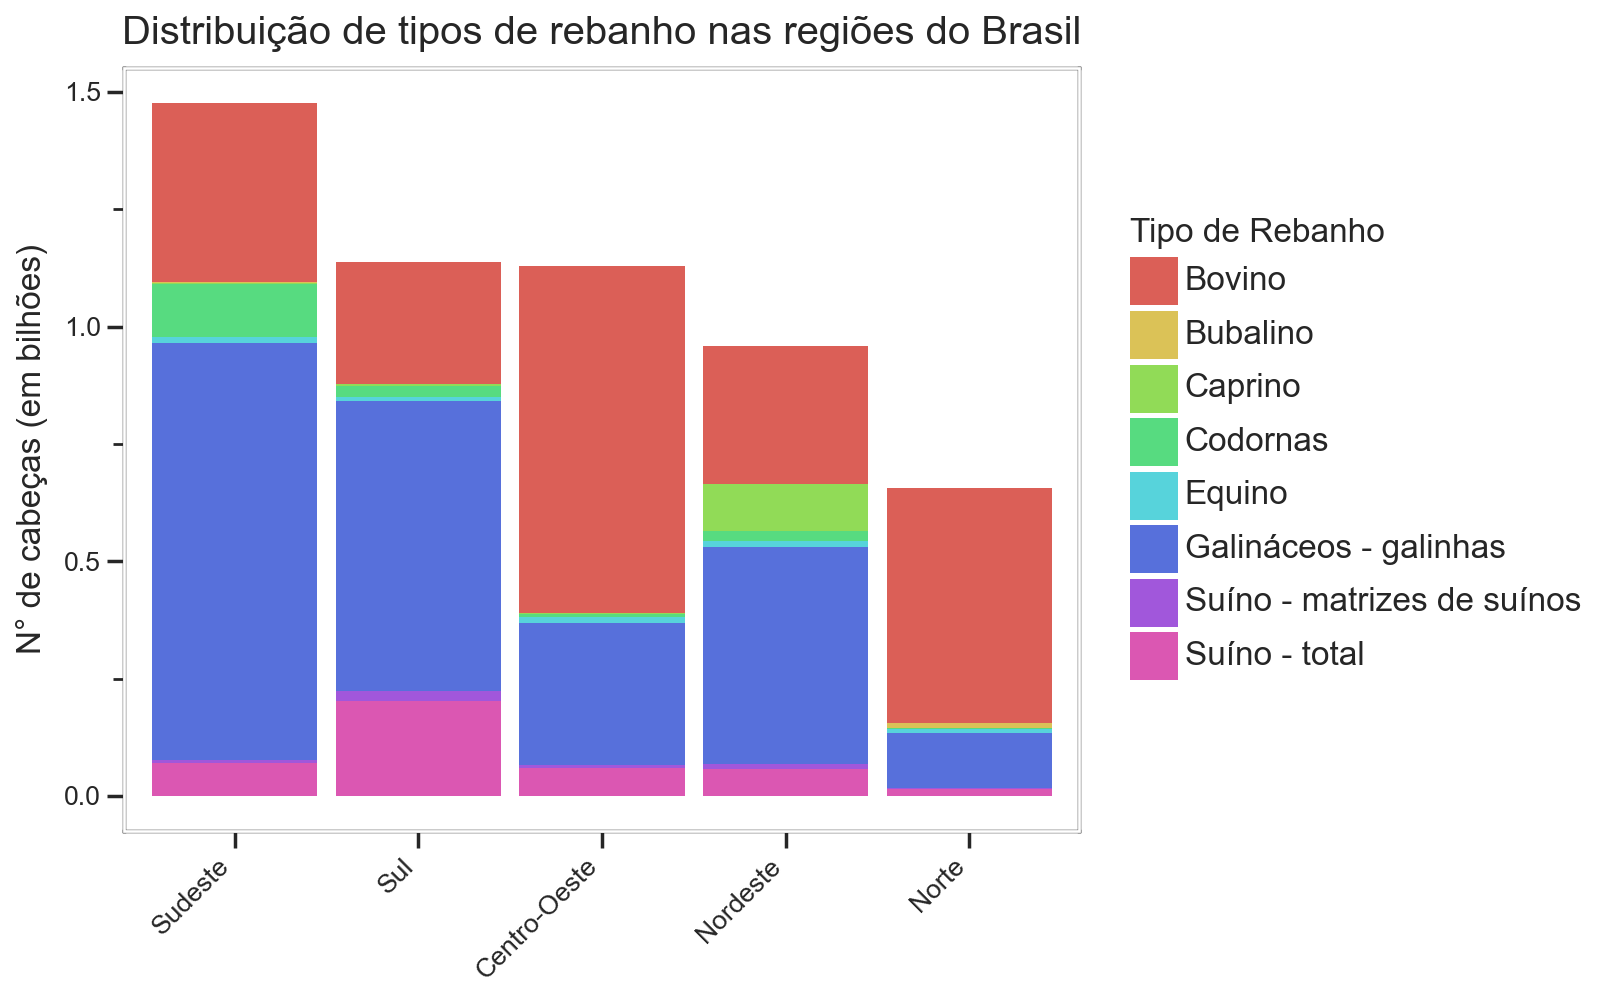

In [44]:
# Agrupa por região e tipo de rebanho, somando as quantidades
df_grouped = (
    flock_df
    .groupby(["nome_regiao", "tipo_rebanho"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()
    .assign(quantidade_bilhoes=lambda _: _.quantidade / ONE_BILLION)
)

# Calcula o total de rebanho para cada região e ordena
state_totals = (df_grouped
	.groupby("nome_regiao")
	.agg(total_estado=("quantidade_bilhoes", "sum"))
	.sort_values("total_estado", ascending=False)
	.reset_index()
)

# Reordena os estados no df principal com base no total
df_grouped = (df_grouped
	.merge(state_totals, on="nome_regiao")
    .assign(
        nome_regiao=lambda _: pd.Categorical(_.nome_regiao, categories=state_totals.nome_regiao, ordered=True)
    )
)

plot = (
    ggplot(df_grouped, aes(x="nome_regiao", y="quantidade_bilhoes", fill="tipo_rebanho"))
    + geom_bar(stat="identity")
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 5),
        panel_grid_major=element_blank()
    )
    + labs(
        title="Distribuição de tipos de rebanho nas regiões do Brasil",
        x="",
        y="N° de cabeças (em bilhões)",
        fill="Tipo de Rebanho"
    )
)

plot.show()

Este gráfico ilustra a distribuição dos tipos de rebanhos nas diferentes regiões do Brasil, evidenciando o volume de cabeças em bilhões.

1. **Centro-Oeste:** A região é a maior produtora de bovinos, refletindo sua forte vocação para a pecuária extensiva e confirmando a especialização dessa região, conforme mencionado anteriormente.
   
2. **Sudeste e Sul:** Ambas as regiões apresentam uma alta concentração de galináceos, o que sugere um foco significativo na avicultura. Além disso, o Sul apresenta uma participação relevante de suínos.

3. **Nordeste:** A região destaca-se pela diversidade, com participação significativa de caprinos e galinhas. A presença expressiva de caprinos é [característica das áreas semiáridas, onde esses animais têm maior adaptabilidade](https://www.embrapa.br/cim-inteligencia-e-mercado-de-caprinos-e-ovinos/apresentacao#:~:text=A%20rusticidade%20dos%20caprinos%20e,da%20%C3%A1rea%20semi%C3%A1rida%20do%20pa%C3%ADs.).

4. **Norte:** Apesar de apresentar volumes menores em comparação com outras regiões, a presença de bovinos é notável, reforçando o papel crescente da pecuária na região amazônica.


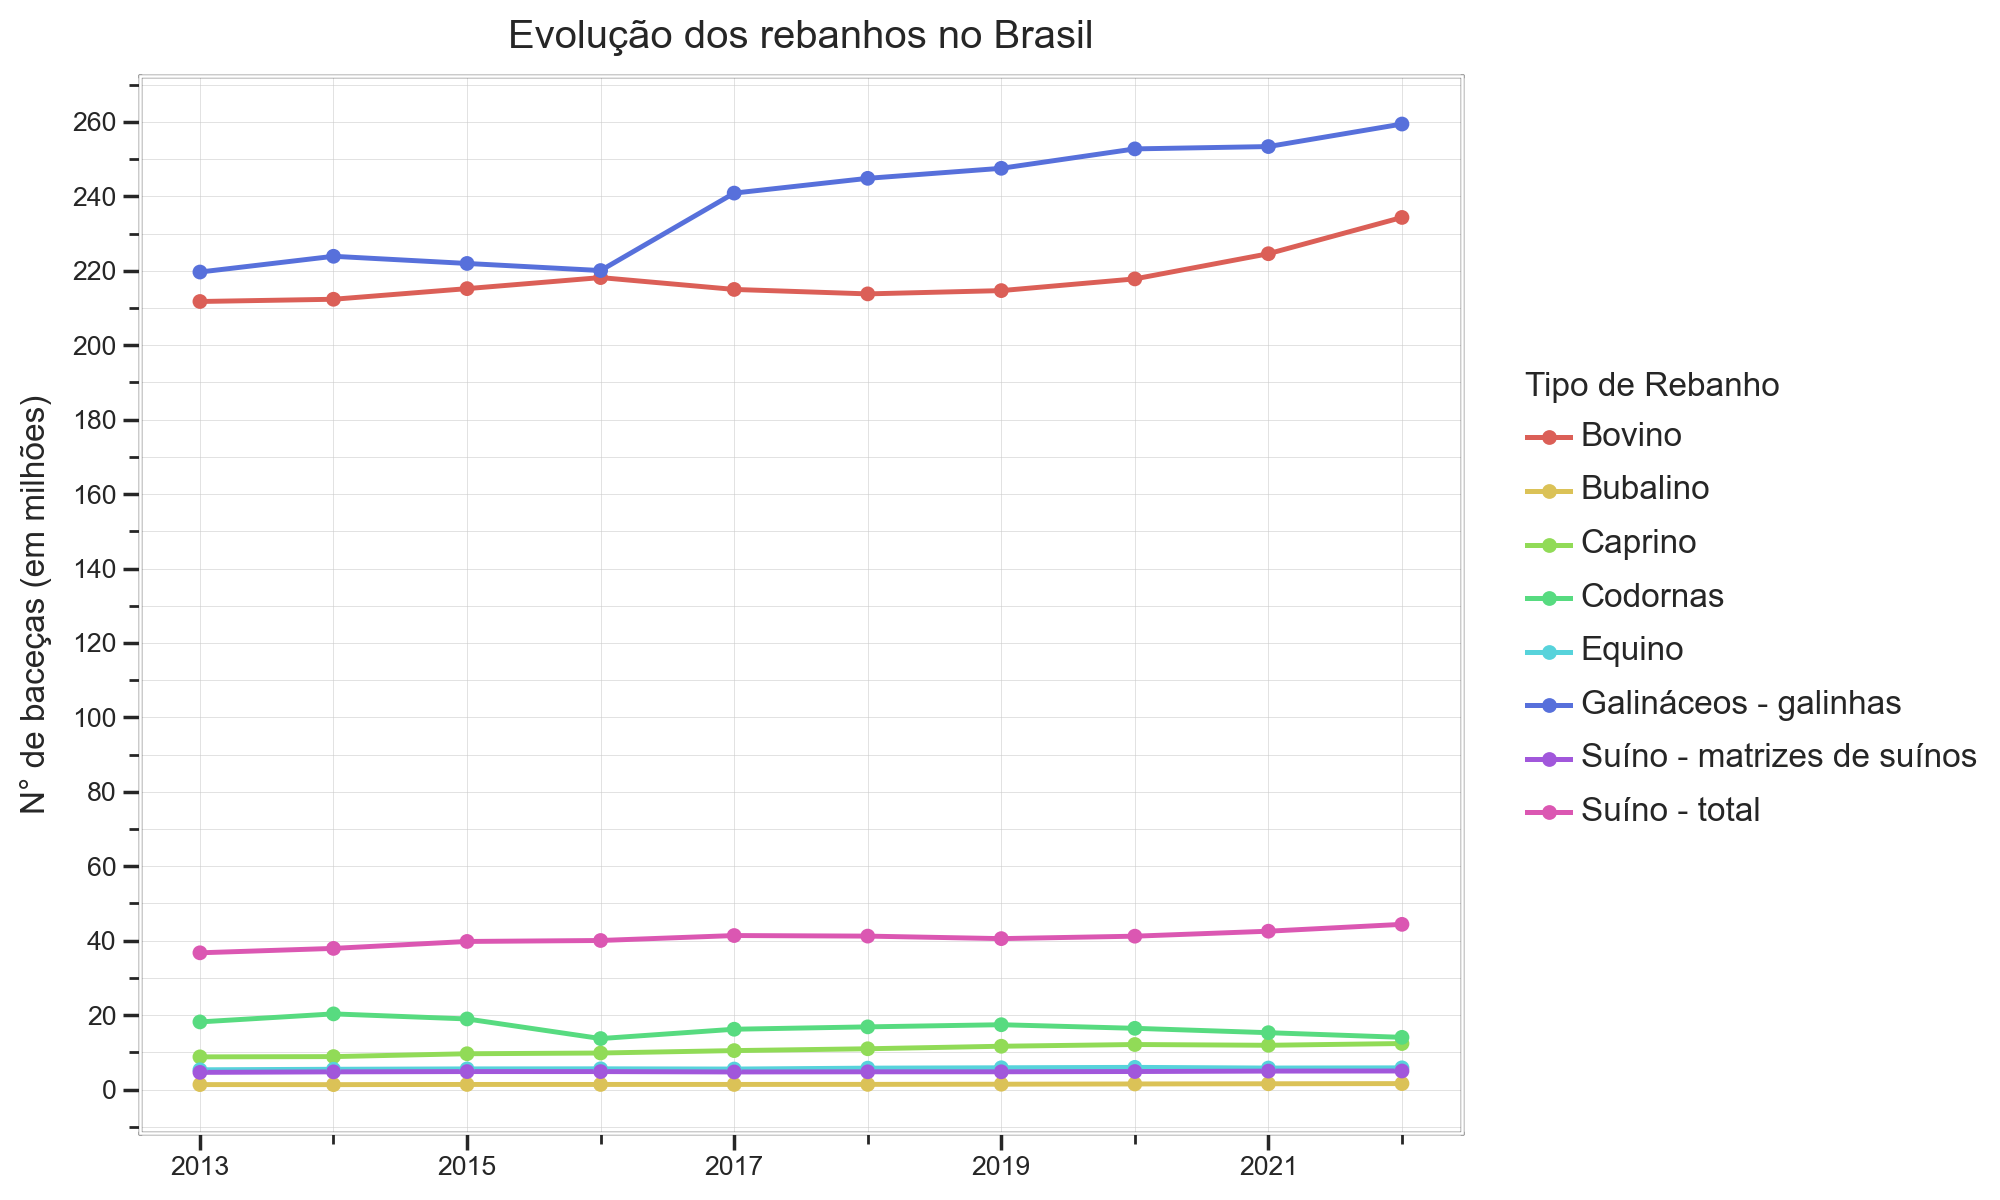

In [45]:
# Agrupa os dados por ano e tipo de rebanho, somando as quantidades
df_temporal = (flock_df
    .groupby(["ano", "tipo_rebanho"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()
    .assign(quantidade_milhoes=lambda _: _.quantidade / ONE_MILLION)
)

plot = (
    ggplot(df_temporal, aes(x="ano", y="quantidade_milhoes", color="tipo_rebanho"))
    + geom_line(size=1)
    + geom_point(size=2)
    + scale_y_continuous(
		breaks=range(0, int(df_temporal.quantidade_milhoes.max()) + 20, 20)
    )
    + scale_x_continuous(
		breaks=range(df_temporal.ano.min(), int(df_temporal.ano.max()) + 2, 2)
    )
    + theme(
        axis_text_x=element_text(hjust=2),
        figure_size=(10, 6),
        panel_grid=element_line(size=0.2)
    )
    + labs(
        title="Evolução dos rebanhos no Brasil",
        x="",
        y="N° de baceças (em milhões)",
        color="Tipo de Rebanho"
    )
)

plot.show()

O rebanho de galináceos foi o que mais cresceu nos últimos anos. Vamos dar uma olhada mais de perto nesse crescimento.

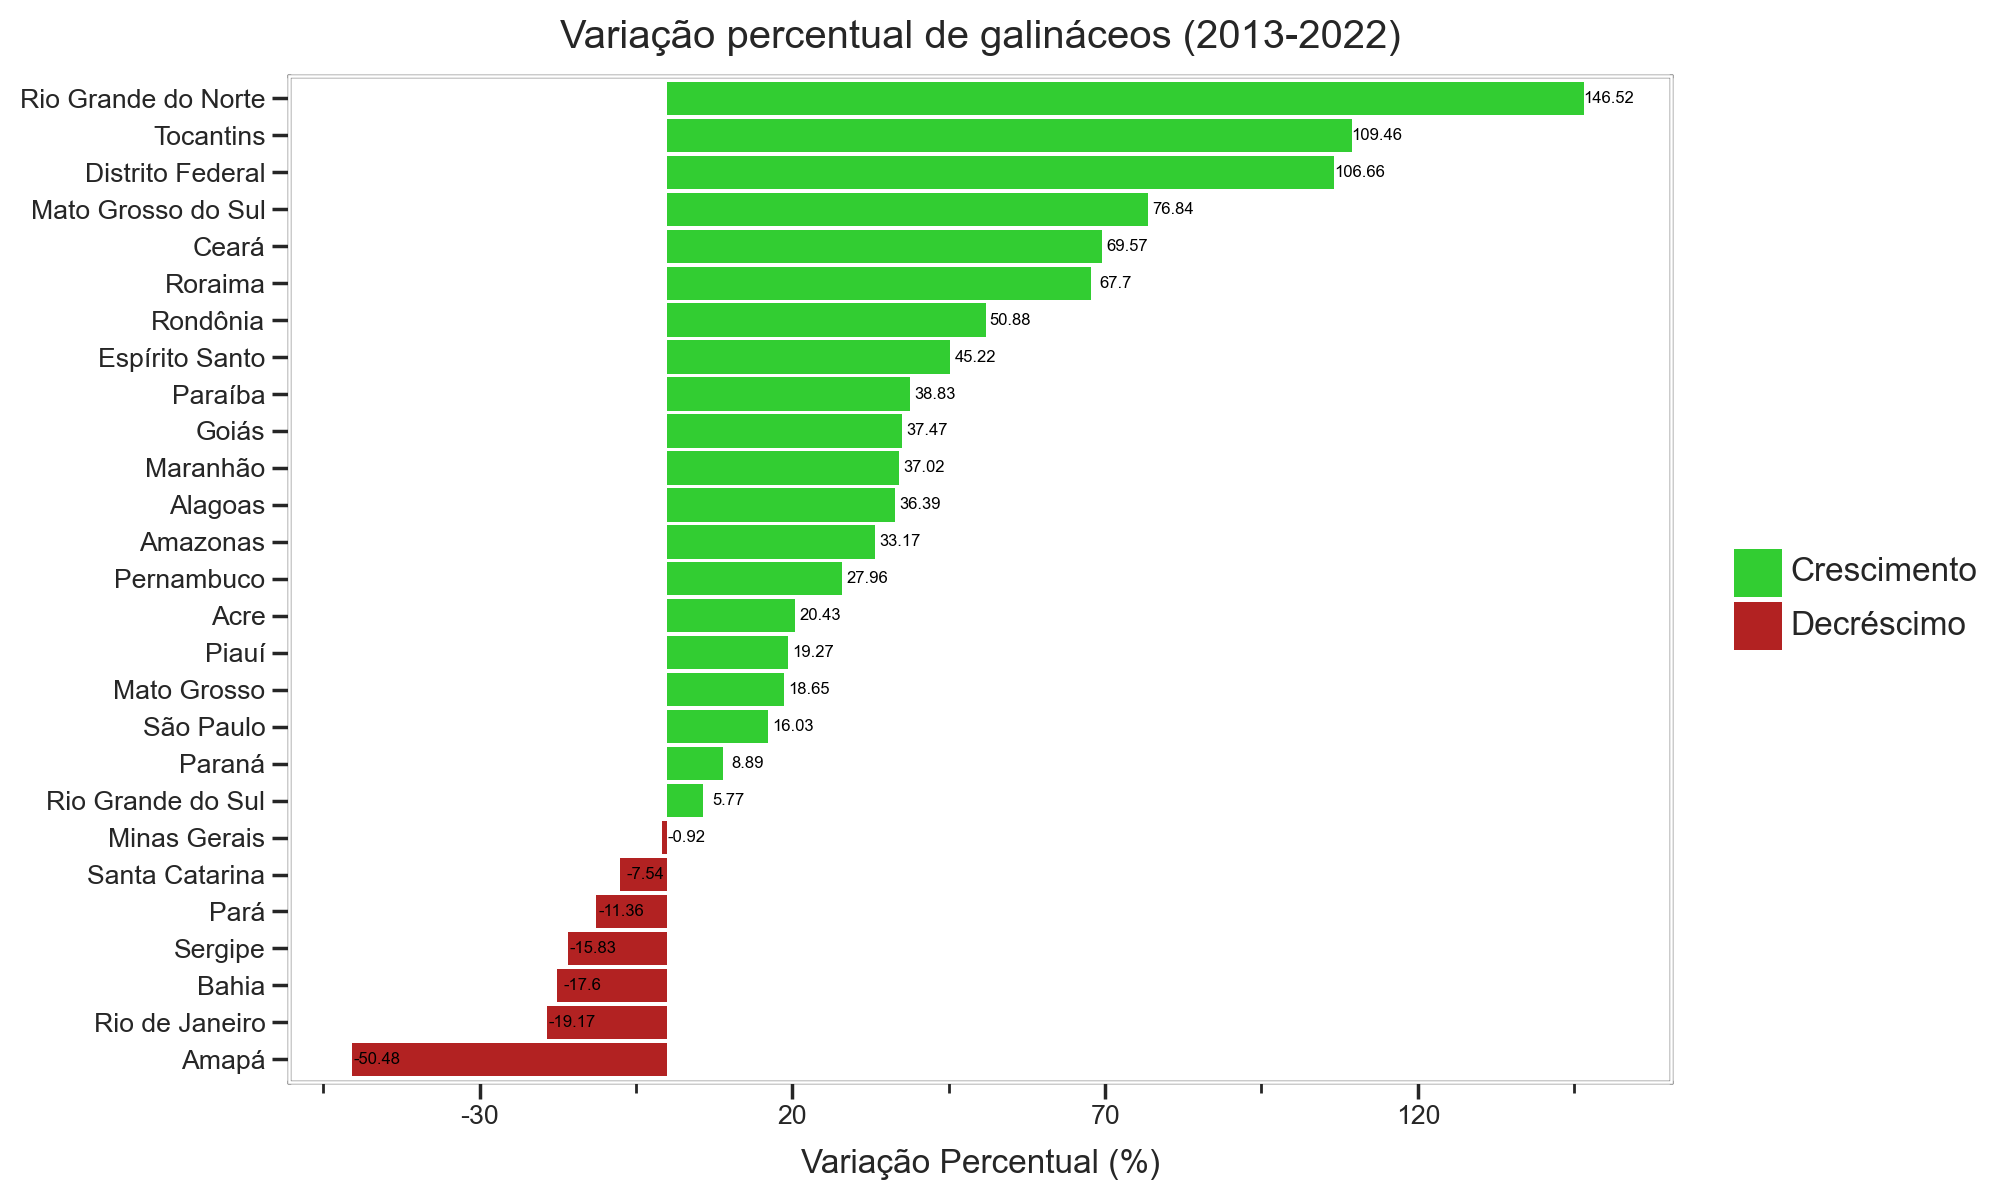

In [46]:
# Filtra os dados para incluir apenas o rebanho de galinaceos
df_galinaceo = flock_df.query("tipo_rebanho == 'Galináceos - galinhas'")

# Agrupa por estado e ano, somando as quantidades
df_galinaceo_agg = (df_galinaceo
    .groupby(["nome_uf", "ano"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()
)

# Obtém os valores de 2013 e 2022 para cada estado
df_growth = (df_galinaceo_agg
    .query("ano in [2013, 2022]")
    .pivot_table(index="nome_uf", columns="ano", values="quantidade")
    .reset_index()
    .assign(crescimento_percentual=lambda df: ((df[2022] - df[2013]) / df[2013]) * 100)
    .assign(cor=lambda _: _.crescimento_percentual.apply(lambda x: 'Crescimento' if x > 0 else 'Decréscimo'))
)

# Ordena pelo variação percentual
df_growth_sorted = df_growth.sort_values(by="crescimento_percentual", ascending=False)

# Cria o gráfico de barras para a variação percentual
plot = (
    ggplot(df_growth_sorted, aes(
        x="reorder(nome_uf, crescimento_percentual)", y="crescimento_percentual", fill="cor"))
    + geom_bar(stat="identity")
    + scale_y_continuous(breaks=range(-80, 400, 50))
    + scale_fill_manual(values={"Crescimento": "limegreen", "Decréscimo": "firebrick"})
    + theme(
        figure_size=(10, 6),
        panel_grid_major_x=element_blank(),
    )
    + labs(
        title="Variação percentual de galináceos (2013-2022)",
        x="",
        y="Variação Percentual (%)",
        fill="",
    )
    + geom_text(
        aes(label=df_growth_sorted.crescimento_percentual.round(2)),
		va="center",
		size=6,
		nudge_y=4
	)
	+ coord_flip()
)

plot.show()

O gráfico exibe a variação percentual no número de galináceos por estado brasileiro entre os anos de 2013 e 2022, evidenciando os estados que tiveram crescimento ou redução na quantidade de aves ao longo do período.

- **Rio Grande do Norte (+146,52%)**: Destacou-se como o estado com maior crescimento percentual de galináceos, mais do que dobrando o número de aves, o que pode indicar investimentos significativos em avicultura ou aumento da demanda local e regional.
- **Tocantins (+109,46%) e Distrito Federal (+106,66%)**: Ambos tiveram crescimentos expressivos, sugerindo uma expansão da avicultura para regiões de menor tradição neste setor.
- Estados como **Mato Grosso do Sul (+76,84%)** e **Ceará (+69,57%)** também mostraram avanços notáveis, sinalizando um potencial aumento na competitividade no mercado.
- **Amapá (-50,48%)**: Apresentou a maior redução percentual, com uma queda expressiva no número de galináceos, o que pode ser reflexo de desafios econômicos, falta de infraestrutura ou mudanças no foco produtivo.
- Estados como **Rio de Janeiro (-19,17%)**, **Bahia (-17,60%)** e **Sergipe (-15,83%)** também registraram quedas significativas, indicando possíveis dificuldades em manter ou expandir a produção.


In [ ]:
# Filtra os municípios do estado de São Paulo
gdf_sp = cities_gdf.query('sigla_uf == "SP"')

# Agrupa o DataFrame de rebanhos por município e calcular o total de rebanhos
df_rebanhos_municipio = (flock_df
	.groupby('id_municipio')
	.agg(quantidade_total=('quantidade', 'sum'))
	.reset_index()
	.assign(quantidade_total_log=lambda _: np.log10(_.quantidade_total))
)

# df_rebanhos_municipio = df_rebanhos_municipio.assign(quantidade_total=lambda _: _.quantidade_total.fillna(0))

# df_rebanhos_municipio = df_rebanhos_municipio.assign(quantidade_total_log=lambda _: np.log10(_.quantidade_total))

# Une os dados de rebanhos com o Geodataframe dos municípios de São Paulo
gdf_sp_rebanhos = gdf_sp.merge(
    df_rebanhos_municipio, left_on='id_municipio', right_on='id_municipio', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
gdf_sp_rebanhos.plot(
    column='quantidade_total_log',  # Coluna de dados para a escala de cor
    cmap='rainbow',  # Esquema de cores
    legend=True,
    ax=ax,
    edgecolor='black'
)

ax.set_title('Quantidade de rebanhos nos municípios\nde São Paulo (escala logarítmica)', fontsize=16)
ax.axis('off')  # Remove os eixos
plt.show()

In [ ]:
# Filtrar os municípios do estado de São Paulo
gdf_sp = cities_gdf.query("sigla_uf == 'SP'")

# Identificar o tipo de rebanho predominante por município
df_rebanhos_predominantes = (flock_df
	.groupby(['municipio', 'tipo_rebanho'])
    .agg(quantidade_total=('quantidade', 'sum'))
    .reset_index()
    .sort_values(by=['municipio', 'quantidade_total'], ascending=False)
    # Manter apenas o rebanho com maior quantidade por município
    .drop_duplicates(subset='municipio')
)

# Unir os dados com o GeoDataFrame dos municípios de São Paulo
gdf_sp_rebanhos_predominantes = gdf_sp.merge(
    df_rebanhos_predominantes, left_on='nome', right_on='municipio', how='left'
)

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_sp_rebanhos_predominantes.plot(
    column='tipo_rebanho',  # Coluna para categorias de rebanho
    cmap='Paired',  # Colormap categórico
    legend=True,
    ax=ax,
    edgecolor='black'
)

# Personalizar o gráfico
ax.set_title('Tipo de Rebanho Predominante por Município em São Paulo', fontsize=16)
ax.axis('off')  # Remove os eixos
plt.show()

In [ ]:
# Identificar o tipo de rebanho predominante por estado
df_rebanhos_estado = (flock_df
    .query('ano == 2022')
    .groupby(['sigla_uf', 'tipo_rebanho'])
    .agg(quantidade_total=('quantidade', 'sum'))
    .reset_index()
    .sort_values(by=['sigla_uf', 'quantidade_total'], ascending=False)
    # Manter apenas o rebanho com maior quantidade por estado
    .drop_duplicates(subset='sigla_uf')
)

# Unir os dados com o GeoDataFrame dos estados
gdf_estados_rebanhos = states_gdf.merge(
    df_rebanhos_estado, left_on='sigla_uf', right_on='sigla_uf', how='left'
)

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf_estados_rebanhos.plot(
    column='tipo_rebanho',  # Coluna para categorias de rebanho
    cmap='Paired',  # Colormap categórico
    legend=True,
    ax=ax,
    edgecolor='black'
)

# Personalizar o gráfico
ax.set_title('Tipo de rebanho predominante por estado no Brasil', fontsize=16)
ax.axis('off')  # Remove os eixos
plt.show()

In [ ]:
# Agrupar os dados por estado e tipo de rebanho para calcular os totais
df_rebanho_agg = (
    flock_df.groupby(['sigla_uf', 'tipo_rebanho'])
    .agg(quantidade_total=('quantidade', 'sum'))
    .reset_index()
    .assign(percentual=lambda _: 100 * _.quantidade_total / _.groupby('tipo_rebanho').quantidade_total.transform('sum'))
)

# Unir os dados de rebanhos com o GeoDataFrame dos estados
gdf_rebanho = states_gdf.merge(
    df_rebanho_agg, left_on='sigla_uf', right_on='sigla_uf', how='left')

# Filtrar e plotar os mapas para cada tipo de rebanho
for tipo in gdf_rebanho.tipo_rebanho.unique():
    # Filtrar os dados para o tipo de rebanho atual
    gdf_rebanho_tipo = gdf_rebanho.query("tipo_rebanho == @tipo")

    # Criar o plot do mapa
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    gdf_rebanho_tipo.plot(
        column='percentual',  # Coluna de percentual
        cmap='viridis',  # Colormap
        legend=True,
        ax=ax,
        edgecolor='black'
    );

    # Adicionar os valores percentuais sobre cada estado
    for geom, percentual in zip(gdf_rebanho_tipo.geometria, gdf_rebanho_tipo.percentual):
        centroid = geom.centroid  # Calcular o centro da geometria
        ax.text(
            centroid.x, centroid.y, f"{percentual:.1f}%",
            ha='center', va='center', fontsize=6, color='chocolate', fontweight='bold'
        )

    # Personalizar o gráfico
    ax.set_title(f"Percentual de Produção - {tipo}", fontsize=14)
    ax.axis("off")  # Remover os eixos
    plt.show()